# Учебная задача «Анализ сайта»

Компания «СберАвтоподписка» хочет увеличить эффективность сайта: улучшить пользовательский опыт, повысить конверсию, сделать рекламные кампании более результативными. Для этого вам предстоит **создать модель, которая предсказывает вероятность того, что пользователь совершит целевое действие (оставит заявку, закажет звонок и пр.) на сайте**.

Эта модель поможет:
- Оценивать эффективность каналов привлечения трафика;
- Адаптировать рекламные кампании;
- Улучшать UX сайта за счет анализа поведения пользователей.

# Выбор моделей

**Особенности нашей задачи:**
- решается задача бинарной классификации 
- в нашем датасете подаляющее большинство признаков - категориальные 
- имеется выраженный дисбаланс классов (доля класса 1 менее 5%)  

**Работа с датасетом:**
- анализ **качества модели** будет производиться на **отложенной** тестовой выборке, видеть ее модель во время обучения **не будет**
- из тренировочной выборки при необходимости будем выделять валидационную

**Выбор моделей:**
- Logistic Regression 
    - простая линейная модель 
    - быстро обучается
- ансамблевые "деревянные" модели (CatBoost, Gradient Boosting, LightGBM) - они отличаются между собой по построению деревьев, оптимизации, скорости работы
    - CatBoost, LightGBM 
        - нативно поддерживают категориальные признаки (хотя нужна их определенная предобработка)
	    - хорошо работают на несбалансированных данных

**Выбор метрик:**
- **НЕЛЬЗЯ** использовать **Accuracy** - модель предсказывающая только класс 0 получит ее значение = 0.95
- **ROC-AUC** (Area Under the ROC Curve) - устойчива к дисбалансу, показывает способность модели различать классы
- **PR-AUC** (Precision-Recall AUC) - более информативна при сильном дисбалансе (фокусируется на положительном классе)


# Подготовка к моделированию

Импортируем библиотеки.

In [2]:
# импорт библиотек

import pandas as pd 
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool,cv
import lightgbm as lgb

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_val_predict, 
    StratifiedKFold)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, 
    roc_curve, 
    auc, 
    average_precision_score, 
    roc_auc_score,
    make_scorer
)
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import optuna

import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings('ignore')

Напишем функцию для анализа обученной модели.

In [3]:
def model_analysis(model, X_test, y_test, probabilities=True):
    '''
    Функция получает предсказание обученной модели на тестовой выборке,
    расчитывает и выводит метрики ROC-AUC, PR-AUC, AP.
    Визуализирует ROC-curve и PR-curve.
    
    Аргументы:
        model: обученная модель
        X_test: наблюдения тестовой выборки
        y_test: метки класов тестовой выборки
        probabilities: если True, то расчитываем вероятности принадлежности классу 1,
                       если False, то просто предсказываем класс
    '''
    if probabilities:
        # предсказываем вероятности для класса 1
        y_pred = model.predict_proba(X_test)[:, 1]
    else:
        # получаем предсказание модели без вероятностей 
        y_pred = model.predict(X_test)
        
    ## Расчитываем метрики

    # --- ROC-AUC ---
    fpr, tpr, _ = roc_curve(y_test, y_pred)  # False Positive Rate, True Positive Rate
    roc_auc = roc_auc_score(y_test, y_pred)  # площадь под ROC-кривой

    # --- PR-AUC-AP ---
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)  # площадь под PR-кривой
    average_precision = average_precision_score(y_test, y_pred)  

    ## Вывод метрик
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    ## Визуализация метрик

    # --- Визуализация ROC-кривой ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Случайный классификатор
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # --- Визуализация PR-кривой ---
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Зафиксируем `random_state` для воспроизводимости.

In [4]:
# для воспроизводимости результатов
RANDOM_STATE = 42

Загрузим датасет, определим числовые и категориальные признаки, разделим датасет.

In [5]:
# загрузка датасета
df = pd.read_csv('data/dataset_for_ml.csv')

# выбираем категориальные признаки
cat_features = df.nunique()[3:].index.to_list()
# выбираем числовые признаки
num_features = df.nunique()[:2].index.to_list()

# разделение на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

#  разделяем на train+val и test (80%/20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  
    random_state=RANDOM_STATE
)

# разделяем train+val на train и val (80%/20% от оставшихся)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 (20% от исходных данных)
    stratify=y_train_val,
    random_state=RANDOM_STATE
)

# Логистическая регрессия

Для логистической регрессии используем One-Hot Encoding для категориальных признаков и стандартизацию для числовых.

## Baseline

Инициализируем простую логистическую регрессию с параметрами по умолчанию.

In [6]:
# cоздаем пайплайн 
model = Pipeline([
    # обработка признаков
    ('preprocessor', ColumnTransformer(
        transformers=[
            # стандартизация числовых признаков
            ('num', StandardScaler(), num_features),
            # OHE категориальных признаков
            ('cat', OneHotEncoder(), cat_features)
        ])
    ),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

In [7]:
%%time
# обучение модели
model.fit(X_train_val, y_train_val)

CPU times: user 4.55 s, sys: 484 ms, total: 5.04 s
Wall time: 5.11 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['event_categories_number',
                                                   'hit_number_median']),
                                                 ('cat', OneHotEncoder(),
                                                  ['top_car_brand',
                                                   'visit_number', 'utm_source',
                                                   'utm_medium',
                                                   'device_category',
                                                   'device_brand',
                                                   'device_browser',
                                                   'geo_country', 'geo_city',
                                                   'month', 'day_of_week',
                                                   'time_of_day',
                                                   'top_car_brand_visit_number_1_1.0',
                                                   'top_car_brand_device_category_1_mobile_device',
                                                   'top_car_brand_geo_country_1_russia',
                                                   'geo_country_month_russia_10'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42))])

ROC-AUC: 0.7973
PR-AUC: 0.1739
Average Precision: 0.1739


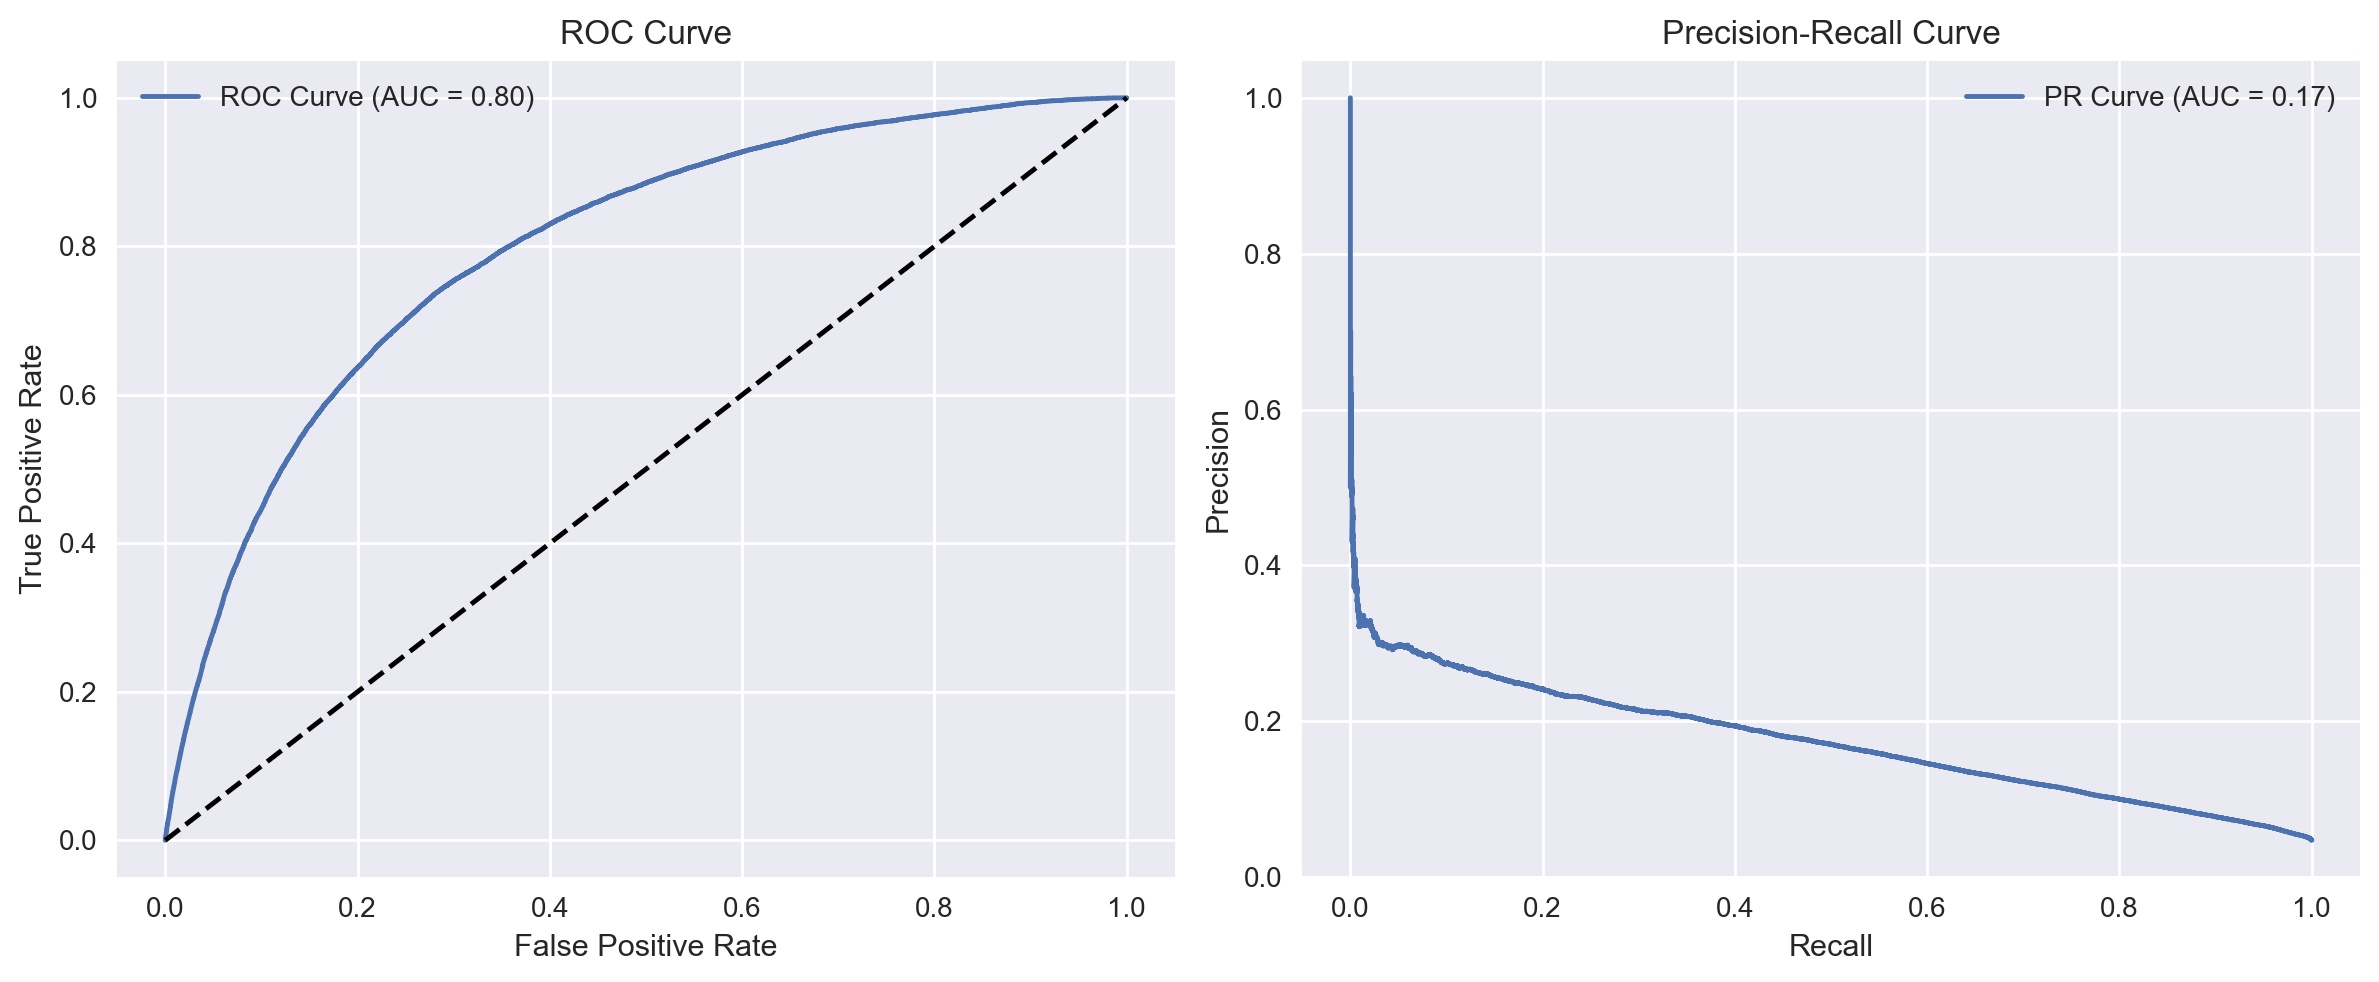

In [8]:
# анализ качества модели на отложенной выборке
model_analysis(model, X_test, y_test)

## Подбор гиперпараметров

In [9]:
# Функция для оптимизации гиперпараметров через Optuna
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 1, log=False),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': trial.suggest_categorical('solver', ['sag', 'saga', 'newton-cg', 'newton-cholesky']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'max_iter': trial.suggest_int('max_iter', 10000, 10000)
    }
    
    model = Pipeline([
    # обработка признаков
    ('preprocessor', ColumnTransformer(
        transformers=[
            # стандартизация числовых признаков
            ('num', StandardScaler(), num_features),
            # OHE категориальных признаков
            ('cat', OneHotEncoder(), cat_features)
        ])
    ),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
    ])
    
    # используем кросс-валидацию на тренировочных данных
    y_proba = cross_val_predict(
        model, X_train_val, y_train_val, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        method='predict_proba',
        n_jobs=-1
    )[:, 1]
    
    return roc_auc_score(y_train_val, y_proba)

In [10]:
%%time
# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2025-05-24 09:54:06,139] A new study created in memory with name: no-name-d43cb903-3e40-4502-9a88-61e971de75b4


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-24 09:54:15,754] Trial 0 finished with value: 0.7971087039191436 and parameters: {'C': 0.25936253238234896, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 0 with value: 0.7971087039191436.
[I 2025-05-24 09:54:24,113] Trial 1 finished with value: 0.7971087039191436 and parameters: {'C': 0.19623497289663322, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 0 with value: 0.7971087039191436.
[I 2025-05-24 09:54:32,809] Trial 2 finished with value: 0.7971087039191436 and parameters: {'C': 0.71848572895091, 'penalty': 'l2', 'solver': 'sag', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 0 with value: 0.7971087039191436.
[I 2025-05-24 09:54:40,651] Trial 3 finished with value: 0.7971087039191436 and parameters: {'C': 0.7696361665271539, 'penalty': 'l2', 'solver': 'newton-cholesky', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 0 with value: 0.7971087

In [11]:
# Лучшие параметры
best_params = study.best_params
print("\nЛучшие параметры модели:")
for k, v in best_params.items():
    print(f"{k}: {v}")


Лучшие параметры модели:
C: 0.25936253238234896
penalty: l2
solver: newton-cg
class_weight: balanced
max_iter: 10000


In [12]:
%%time
# Обучение финальной модели на всех тренировочных данных
final_model = Pipeline([
    # обработка признаков
    ('preprocessor', ColumnTransformer(
        transformers=[
            # стандартизация числовых признаков
            ('num', StandardScaler(), num_features),
            # OHE категориальных признаков
            ('cat', OneHotEncoder(), cat_features)
        ])
    ),
    ('classifier', LogisticRegression(
        **best_params,
        random_state=RANDOM_STATE
    ))
    ])

final_model.fit(X_train_val, y_train_val)

CPU times: user 5.16 s, sys: 786 ms, total: 5.95 s
Wall time: 6.09 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['event_categories_number',
                                                   'hit_number_median']),
                                                 ('cat', OneHotEncoder(),
                                                  ['top_car_brand',
                                                   'visit_number', 'utm_source',
                                                   'utm_medium',
                                                   'device_category',
                                                   'device_brand',
                                                   'device_browser',
                                                   'geo_country', 'geo_city',
                                                   'month', 'day_of_week',
                                                   'time_of_day',
                                                   'top_car_brand_visit_number_1_1.0',
                                                   'top_car_brand_device_category_1_mobile_device',
                                                   'top_car_brand_geo_country_1_russia',
                                                   'geo_country_month_russia_10'])])),
                ('classifier',
                 LogisticRegression(C=0.25936253238234896,
                                    class_weight='balanced', max_iter=10000,
                                    random_state=42, solver='newton-cg'))])

ROC-AUC: 0.7973
PR-AUC: 0.1739
Average Precision: 0.1739


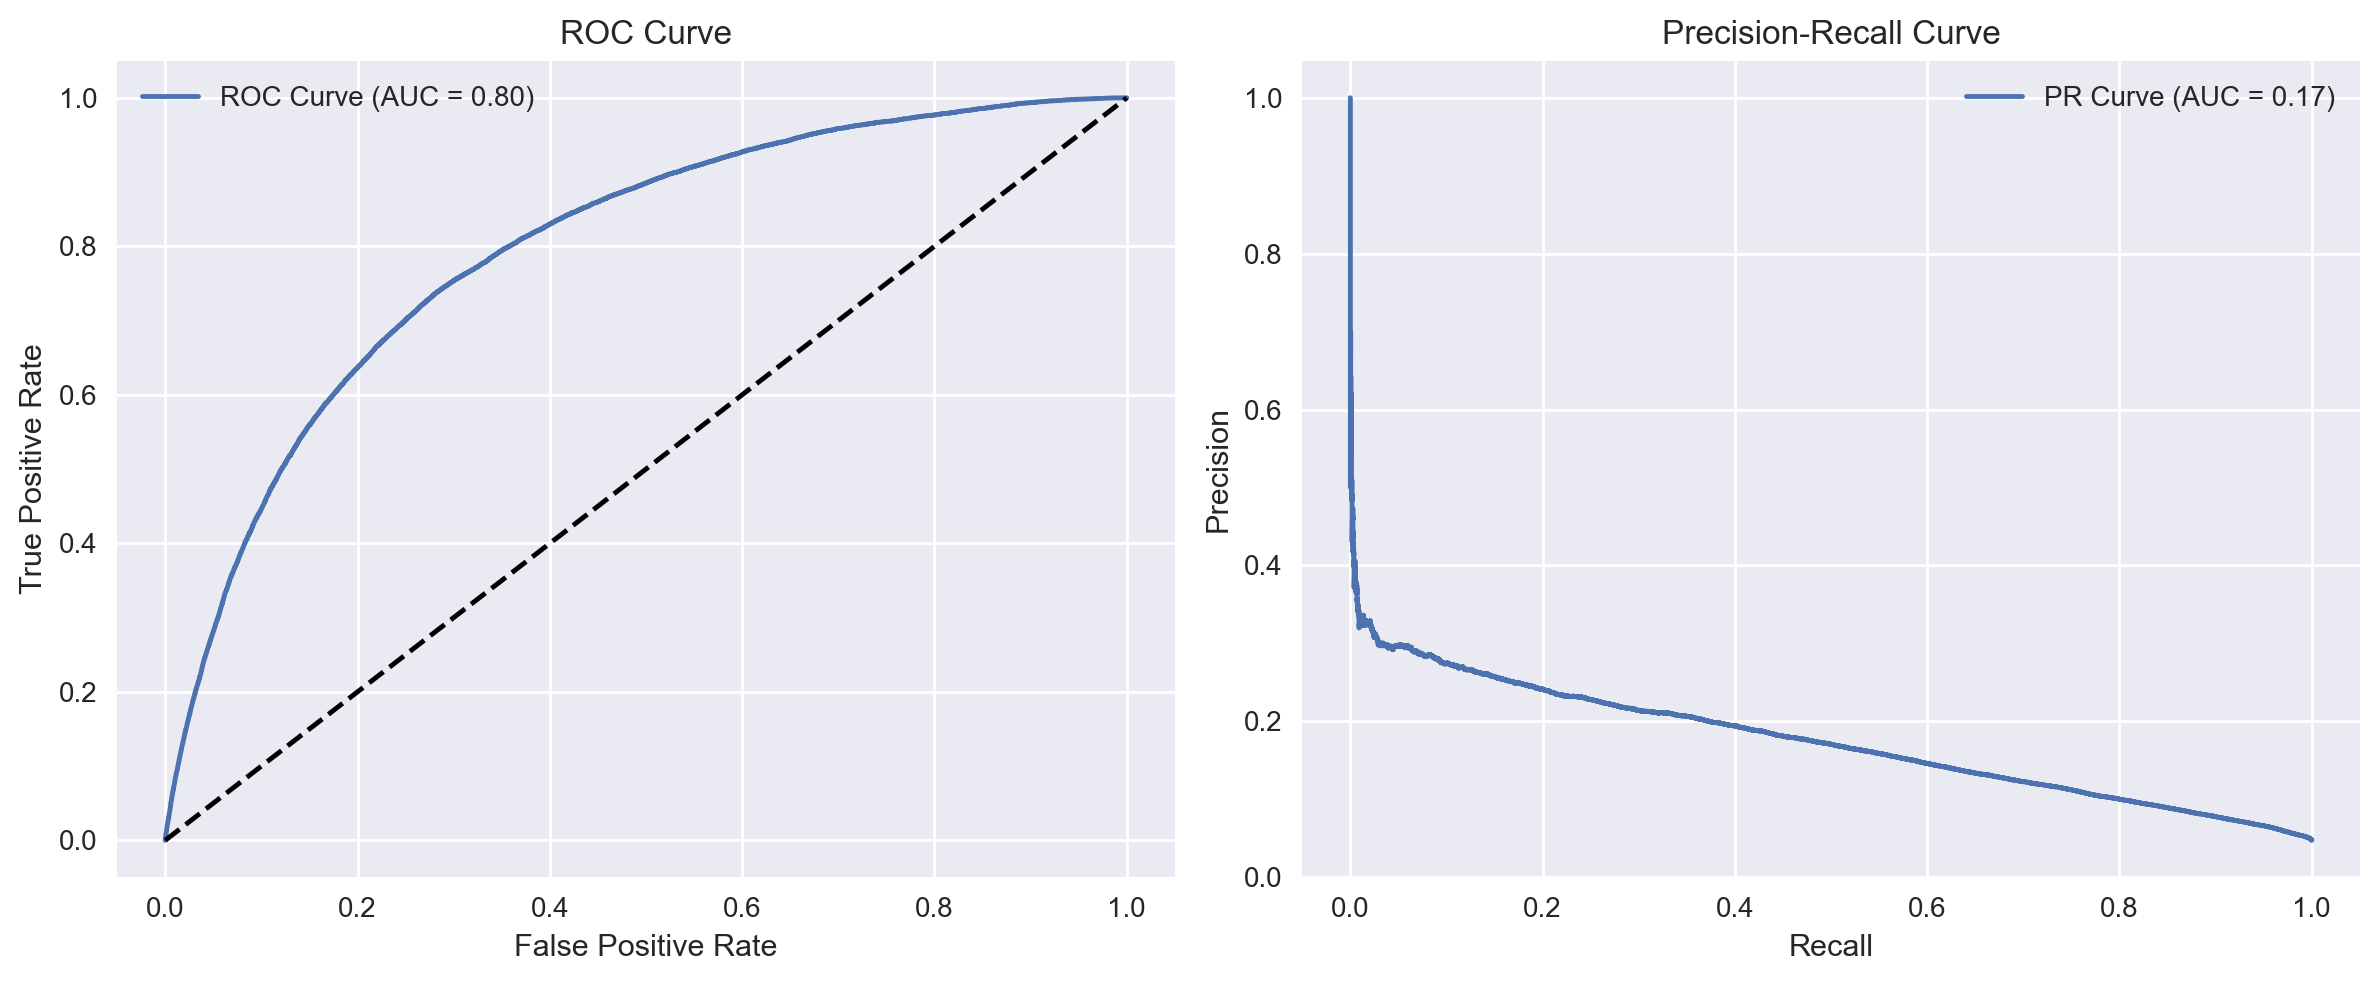

In [13]:
# анализ качества модели с подбором гиперпараметров на отложенной выборке
model_analysis(final_model, X_test, y_test)

Разницы в метриках нет, уличшить модель через подбор гиперпараметров не получилось.

## Сохранение модели

Сохраним начальную модель.

In [ ]:
## Сохранение обученной модели

# формат .joblib
joblib.dump(model, 'models/logistic_regression_model.joblib')
# формат .pkl
with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Оценка важности признаков

ТOP-5 Features by Absolute Coefficient Value


,Feature,Coefficient,Abs_Coefficient
0,num__event_categories_number,0.689878,0.689878
22,cat__utm_medium_7,-0.657280,0.657280
15,cat__utm_medium_0,0.655110,0.655110
17,cat__utm_medium_2,-0.571684,0.571684
10,cat__utm_source_1,-0.559951,0.559951


Features with Lowest Predictive Power (Top 5)


,Feature,Coefficient,Abs_Coefficient
30,cat__device_brand_xiaomi,-0.011139,0.011139
33,cat__device_browser_edge,-0.008488,0.008488
2,cat__top_car_brand_0,-0.005559,0.005559
32,cat__device_browser_chrome,-0.003473,0.003473
68,cat__top_car_brand_geo_country_1_russia_0,-0.000668,0.000668


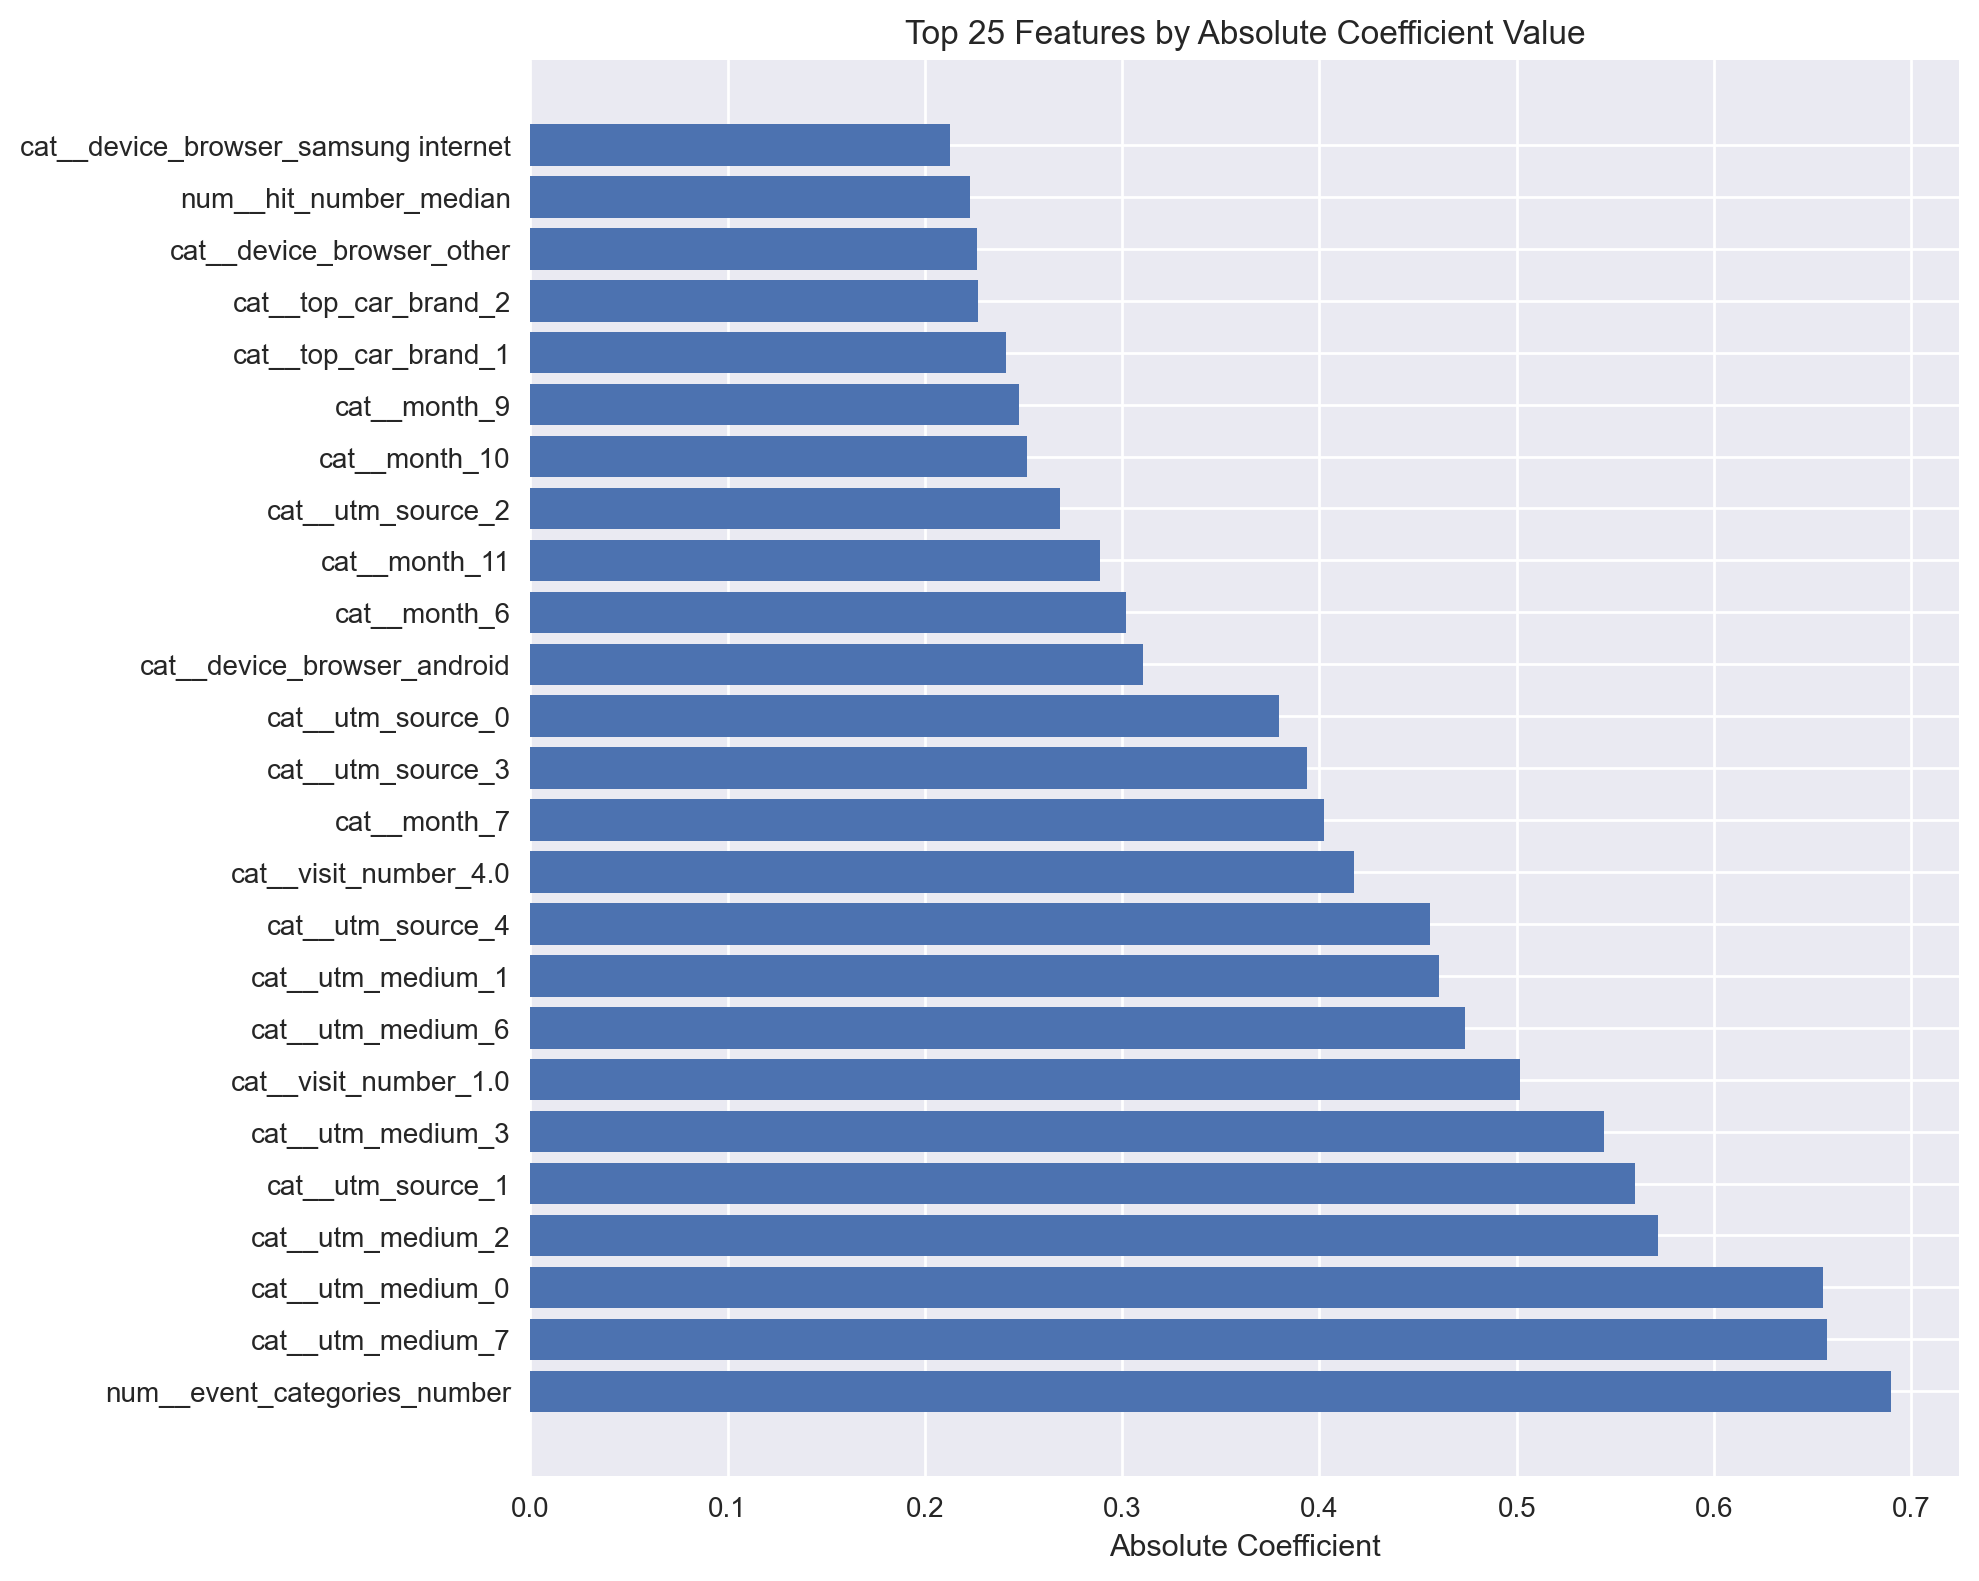

In [14]:
# получаем имена признаков после преобразования
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
 
# получаем коэффициенты модели
coefficients = model.named_steps['classifier'].coef_[0]

# создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# ввод топ-5 самых важных и 5 наименее важных признаков
print("ТOP-5 Features by Absolute Coefficient Value")
display(feature_importance.head())
print("Features with Lowest Predictive Power (Top 5)")
display(feature_importance.tail())

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'][:25], 
         feature_importance['Abs_Coefficient'][:25])
plt.title('Top 25 Features by Absolute Coefficient Value')
plt.xlabel('Absolute Coefficient')
plt.tight_layout()
plt.show()

## Выводы:
- модель обучалась 5сек, с подбором гиперпараметров 1мин23сек
- модель достигла метрик *ROC-AUC*: 0.7973, *PR-AUC*: 0.1739
- подбор гиперпараметров не повлиял на качество метрик
- наиболее важные признаки:
    - `num__event_categories_number` - чем выше количество действий, совершаемых пользователем, тем выше его вероятность принадлежности к классу 1
    - `utm-medium` - тип привлечения, различные значения данного признака как положительно, так и отрицательно влияют на вероятность принадлежности пользователя к классу 1
    - `utm_source` - канал привлечения
- наименее важные признаки:
    - использование пользователем устройства Xiaomi, браузеров Edge и Chrome

# CatBoost

In [15]:
## Работа с признаками

# переводим значения категориальных признаков в строковый тип
for col in cat_features:
    X_train_val[col] = X_train_val[col].astype(str)
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# cоздание Pool объектов (оптимизированный формат данных для CatBoost)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

## Baseline

In [16]:
%%time
## Обучение модели

# параметры модели с учетом дисбаланса
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'auto_class_weights': 'Balanced',  
    'eval_metric': 'AUC',  
    'early_stopping_rounds': 50
}

# обучение модели
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=val_pool)

0:	test: 0.8066035	best: 0.8066035 (0)	total: 488ms	remaining: 8m 7s
100:	test: 0.8501837	best: 0.8501837 (100)	total: 30.3s	remaining: 4m 30s
200:	test: 0.8576540	best: 0.8576540 (200)	total: 58.9s	remaining: 3m 54s
300:	test: 0.8620635	best: 0.8620635 (300)	total: 1m 29s	remaining: 3m 27s
400:	test: 0.8652919	best: 0.8652919 (400)	total: 2m 2s	remaining: 3m 3s
500:	test: 0.8670941	best: 0.8670941 (500)	total: 2m 34s	remaining: 2m 34s
600:	test: 0.8684952	best: 0.8684952 (600)	total: 3m 6s	remaining: 2m 3s
700:	test: 0.8695455	best: 0.8695455 (700)	total: 3m 38s	remaining: 1m 33s
800:	test: 0.8701811	best: 0.8701829 (799)	total: 4m 10s	remaining: 1m 2s
900:	test: 0.8706833	best: 0.8706851 (898)	total: 4m 43s	remaining: 31.1s
999:	test: 0.8710834	best: 0.8710855 (998)	total: 5m 15s	remaining: 0us

bestTest = 0.8710854991
bestIteration = 998

Shrink model to first 999 iterations.
CPU times: user 40min 36s, sys: 36.9 s, total: 41min 13s
Wall time: 5min 16s


ROC-AUC: 0.8711
PR-AUC: 0.2402
Average Precision: 0.2402


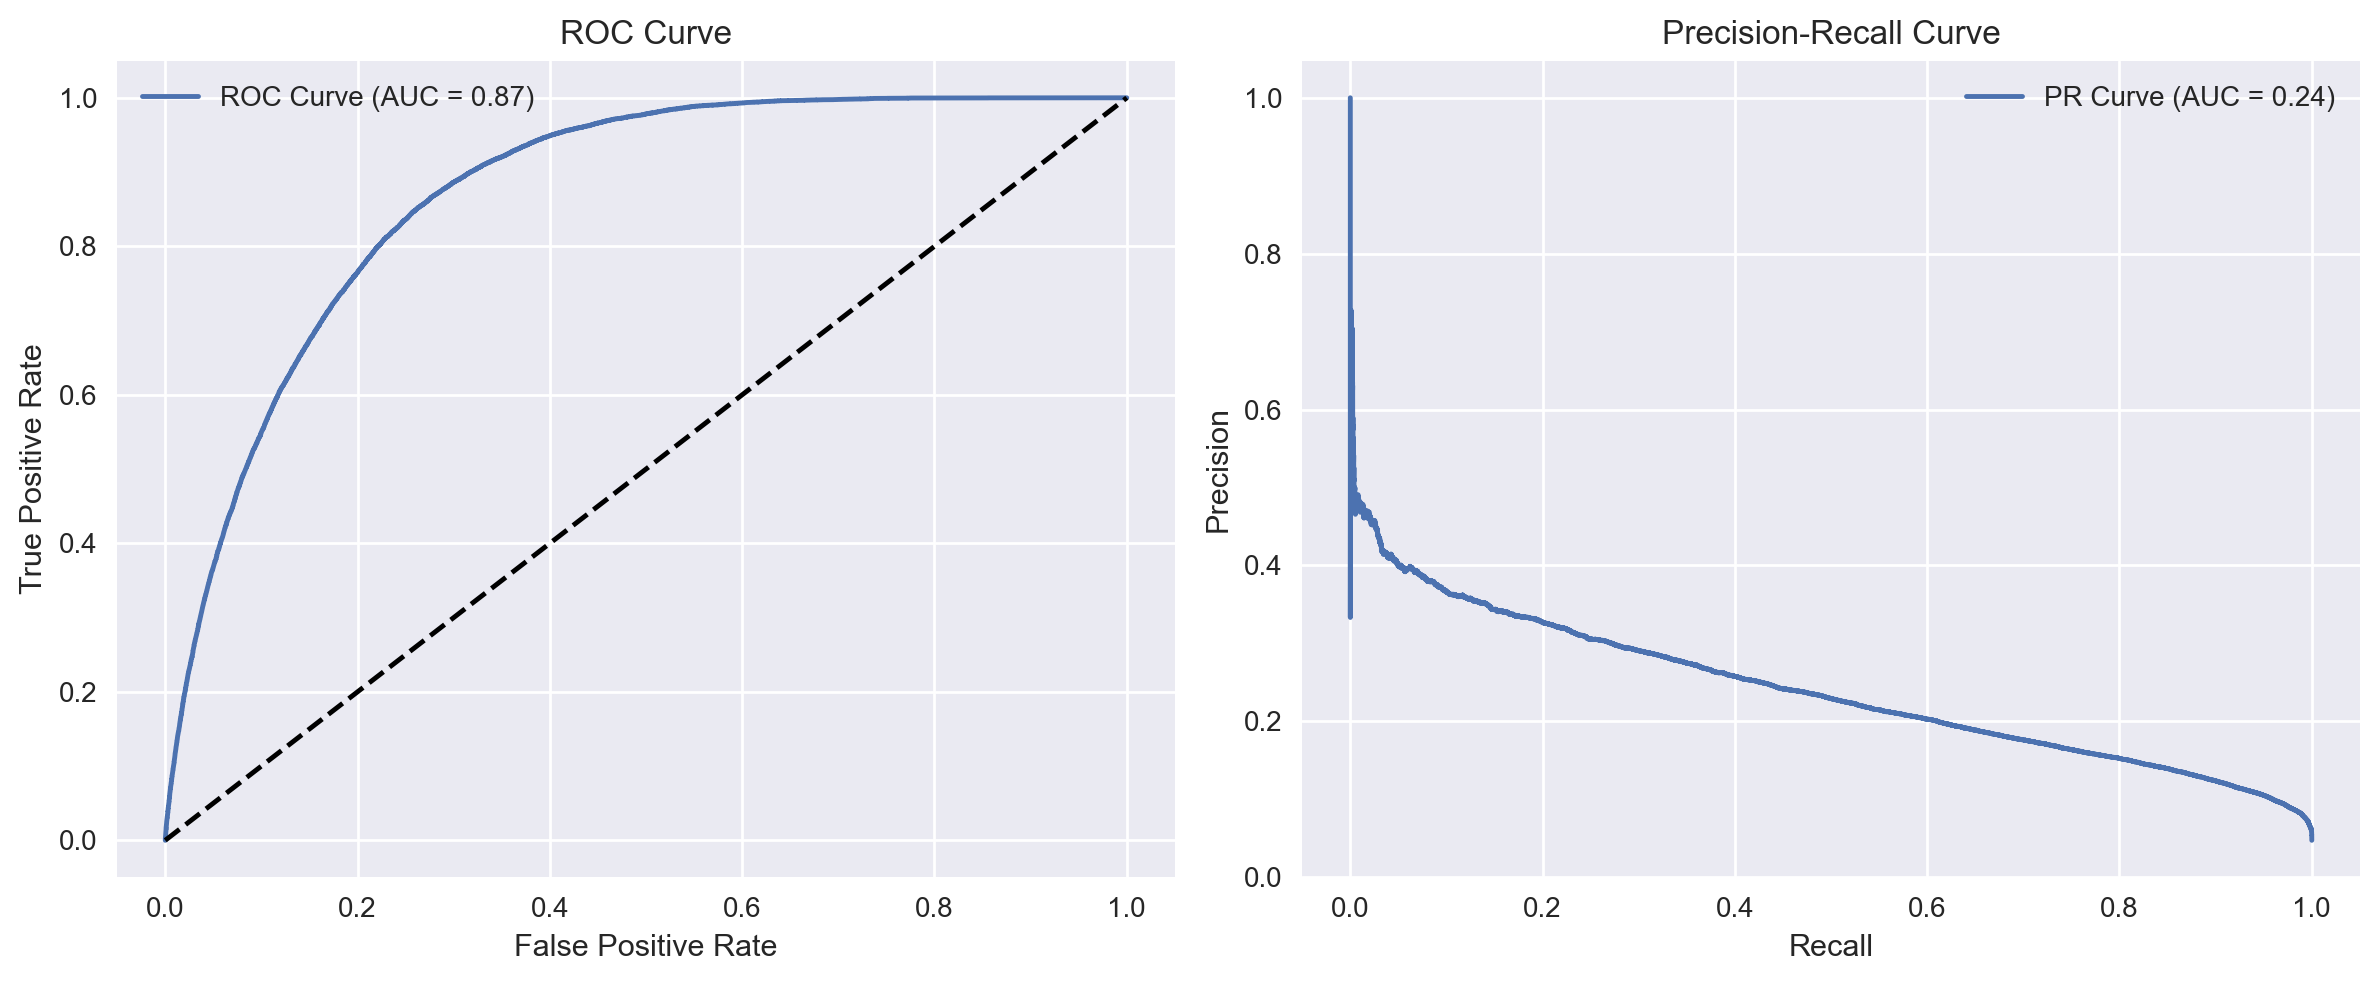

In [17]:
# анализ качества модели на отложенной выборке
model_analysis(model, X_test, y_test)

Метрика значительно улучшилась, по сравнению с моделью Логистической регрессии.

## Кросс-валидация

In [18]:
%%time
# параметры модели
params = {
    'iterations': 1000,                  
    'learning_rate': 0.03,               
    'depth': 6,                          
    'loss_function': 'Logloss',          
    'eval_metric': 'AUC',                
    'early_stopping_rounds': 50,         
    'random_seed': RANDOM_STATE,                   
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1]),  # Балансировка классов
    'od_type': 'Iter',                  
    #'od_wait': 20,                       
    'verbose': 100                      
}

# кросс-валидация (5 фолдов)
cv_results = cv(
    pool=train_pool,
    params=params,
    fold_count=5,               
    stratified=True,            
    partition_random_seed=RANDOM_STATE,
    plot=True,                  
    shuffle=True              
)

# определение лучшего числа итераций
best_iter = np.argmax(cv_results['test-AUC-mean'])
print(f'Best iteration: {best_iter}, Best AUC: {cv_results["test-AUC-mean"].max():.4f}')

# задаем финальную модель с лучшими параметрами
final_model = CatBoostClassifier(
    **{**params, 'iterations': best_iter}  
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	test: 0.8063425	best: 0.8063425 (0)	total: 405ms	remaining: 6m 44s
100:	test: 0.8444952	best: 0.8444952 (100)	total: 24.8s	remaining: 3m 40s
200:	test: 0.8539253	best: 0.8539253 (200)	total: 48.7s	remaining: 3m 13s
300:	test: 0.8575129	best: 0.8575133 (298)	total: 1m 12s	remaining: 2m 48s
400:	test: 0.8601399	best: 0.8601399 (400)	total: 1m 35s	remaining: 2m 22s
500:	test: 0.8624346	best: 0.8624346 (500)	total: 2m	remaining: 1m 59s
600:	test: 0.8647964	best: 0.8647964 (600)	total: 2m 27s	remaining: 1m 37s
700:	test: 0.8661292	best: 0.8661292 (700)	total: 2m 52s	remaining: 1m 13s
800:	test: 0.8671593	best: 0.8671593 (800)	total: 3m 18s	remaining: 49.3s
900:	test: 0.8679723	best: 0.8679723 (900)	total: 3m 43s	remaining: 24.6s
999:	test: 0.8687121	best: 0.8687139 (996)	total: 4m 9s	remaining: 0us

bestTest = 0.8687139498
bestIteration = 996

Training on fold [1/5]
0:	test: 0.8036114	best: 0.8036114 (0)	total: 462ms	remaining: 7m 41s
100:	test: 0.8408051	best: 0.8

In [19]:
%%time
# обучаем лучшую модель
final_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,        
    verbose=100
)


0:	test: 0.8066035	best: 0.8066035 (0)	total: 477ms	remaining: 7m 55s
100:	test: 0.8413054	best: 0.8413054 (100)	total: 31.8s	remaining: 4m 43s
200:	test: 0.8521056	best: 0.8521056 (200)	total: 1m 1s	remaining: 4m 3s
300:	test: 0.8563917	best: 0.8563917 (300)	total: 1m 29s	remaining: 3m 26s
400:	test: 0.8585240	best: 0.8585240 (400)	total: 1m 57s	remaining: 2m 54s
500:	test: 0.8611513	best: 0.8611513 (500)	total: 2m 29s	remaining: 2m 28s
600:	test: 0.8632649	best: 0.8632649 (600)	total: 3m 1s	remaining: 2m
700:	test: 0.8648334	best: 0.8648334 (700)	total: 3m 33s	remaining: 1m 30s
800:	test: 0.8661041	best: 0.8661041 (800)	total: 4m 6s	remaining: 1m
900:	test: 0.8672965	best: 0.8672965 (900)	total: 4m 38s	remaining: 30.3s
998:	test: 0.8680459	best: 0.8680459 (998)	total: 5m 10s	remaining: 0us

bestTest = 0.8680459327
bestIteration = 998

CPU times: user 39min 28s, sys: 45.7 s, total: 40min 14s
Wall time: 5min 11s


ROC-AUC: 0.8680
PR-AUC: 0.2311
Average Precision: 0.2312


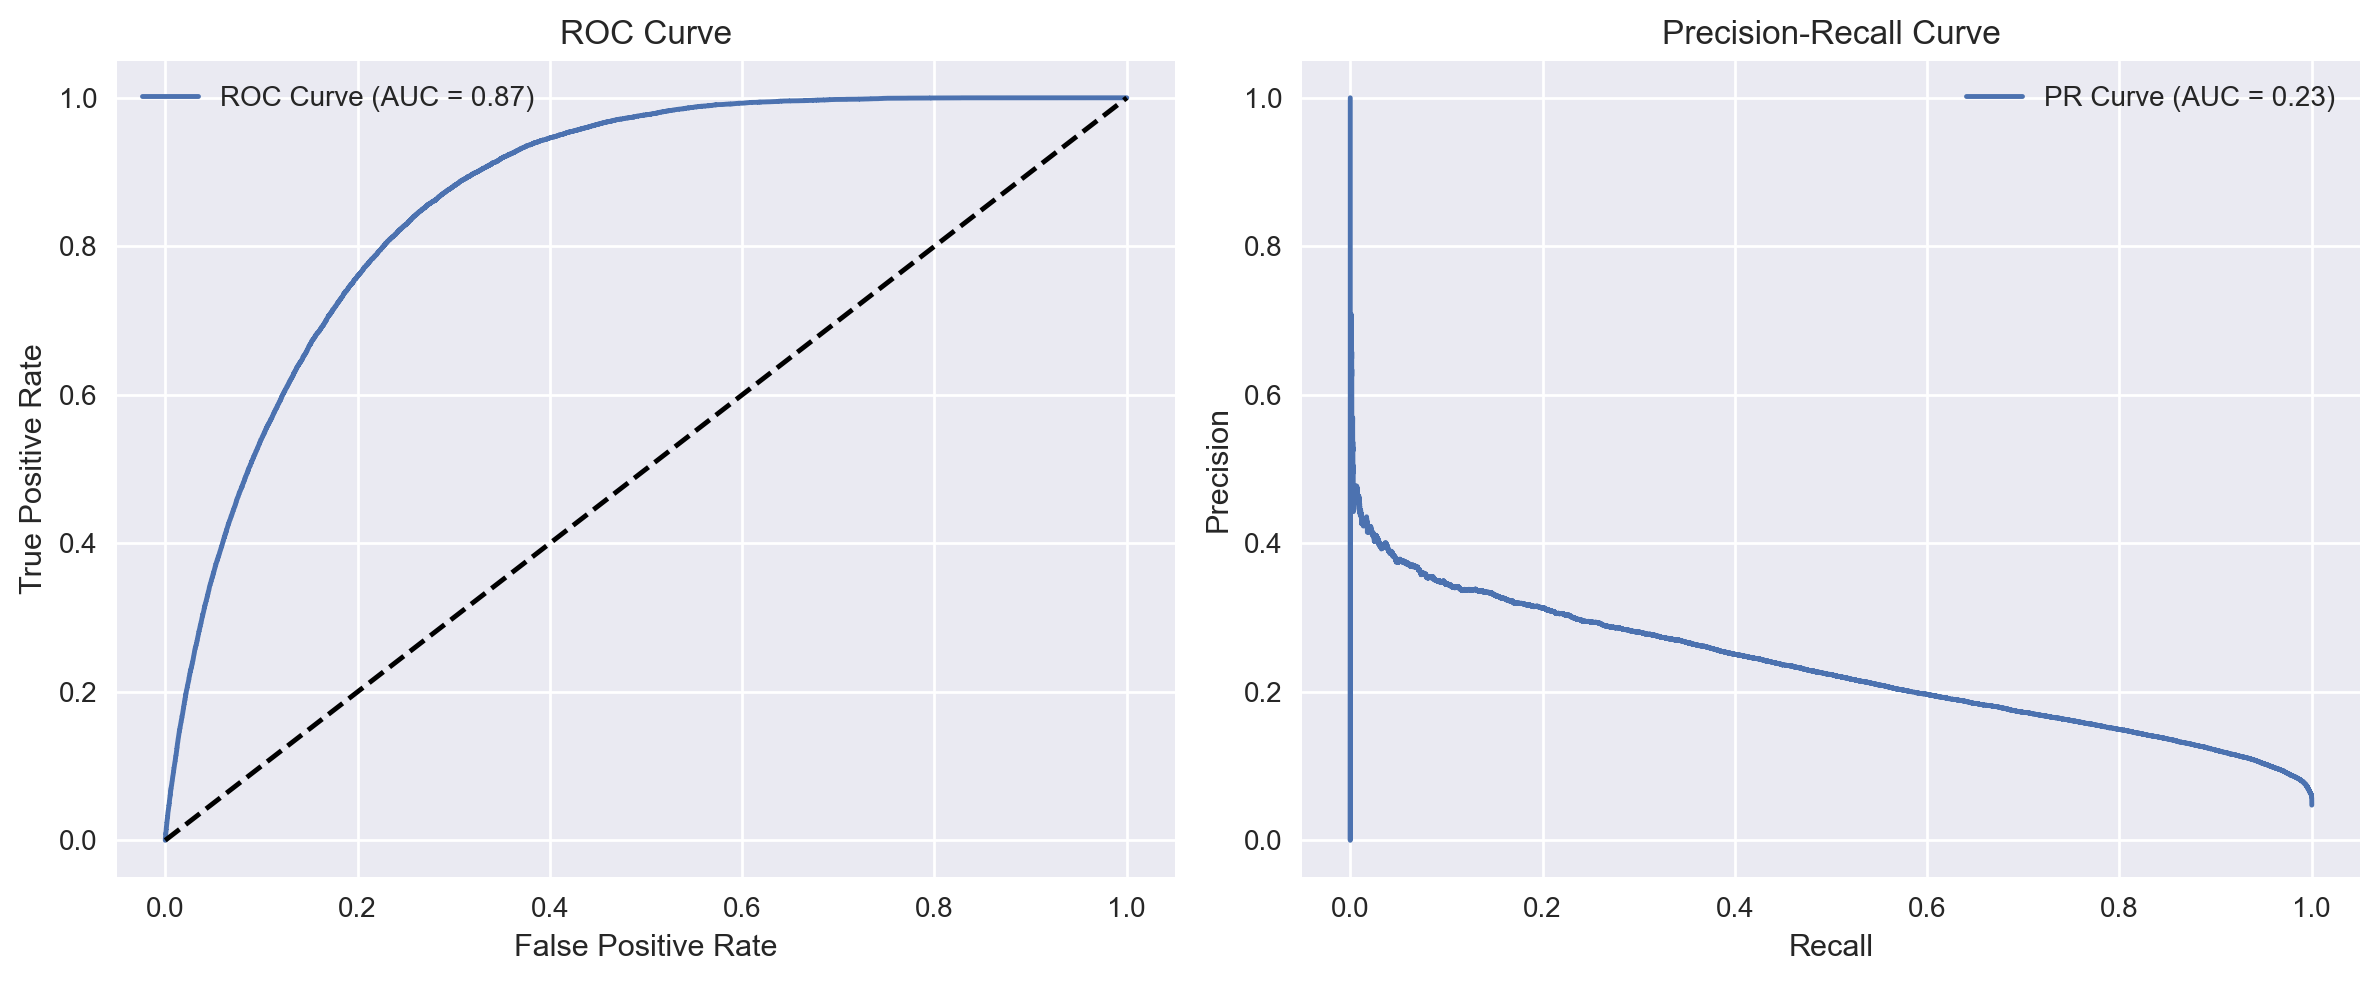

In [20]:
# анализ качества модели на отложенной выборке
model_analysis(final_model, X_test, y_test)

Метрика стала чуть хуже.

## Сохранение модели

Сохраним первую обученную модель CatBoost.

In [ ]:
## Сохранение обученной модели

# бинарный формат
model.save_model('models/catboost_model.cbm')  
# формат .json
model.save_model('models/catboost_model.json', format='json')  
# формат .pkl
with open('models/catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)


## Оценка важности признаков

ТOP-5 Features by Absolute Coefficient Value


,Feature,Importance
0,event_categories_number,38.526509
4,utm_source,17.366072
1,hit_number_median,15.589003
5,utm_medium,6.676042
3,visit_number,6.236154


Features with Lowest Predictive Power (Top 5)


,Feature,Importance
14,top_car_brand_visit_number_1_1.0,0.357876
15,top_car_brand_device_category_1_mobile_device,0.356917
10,geo_city,0.313024
16,top_car_brand_geo_country_1_russia,0.280491
9,geo_country,0.092608


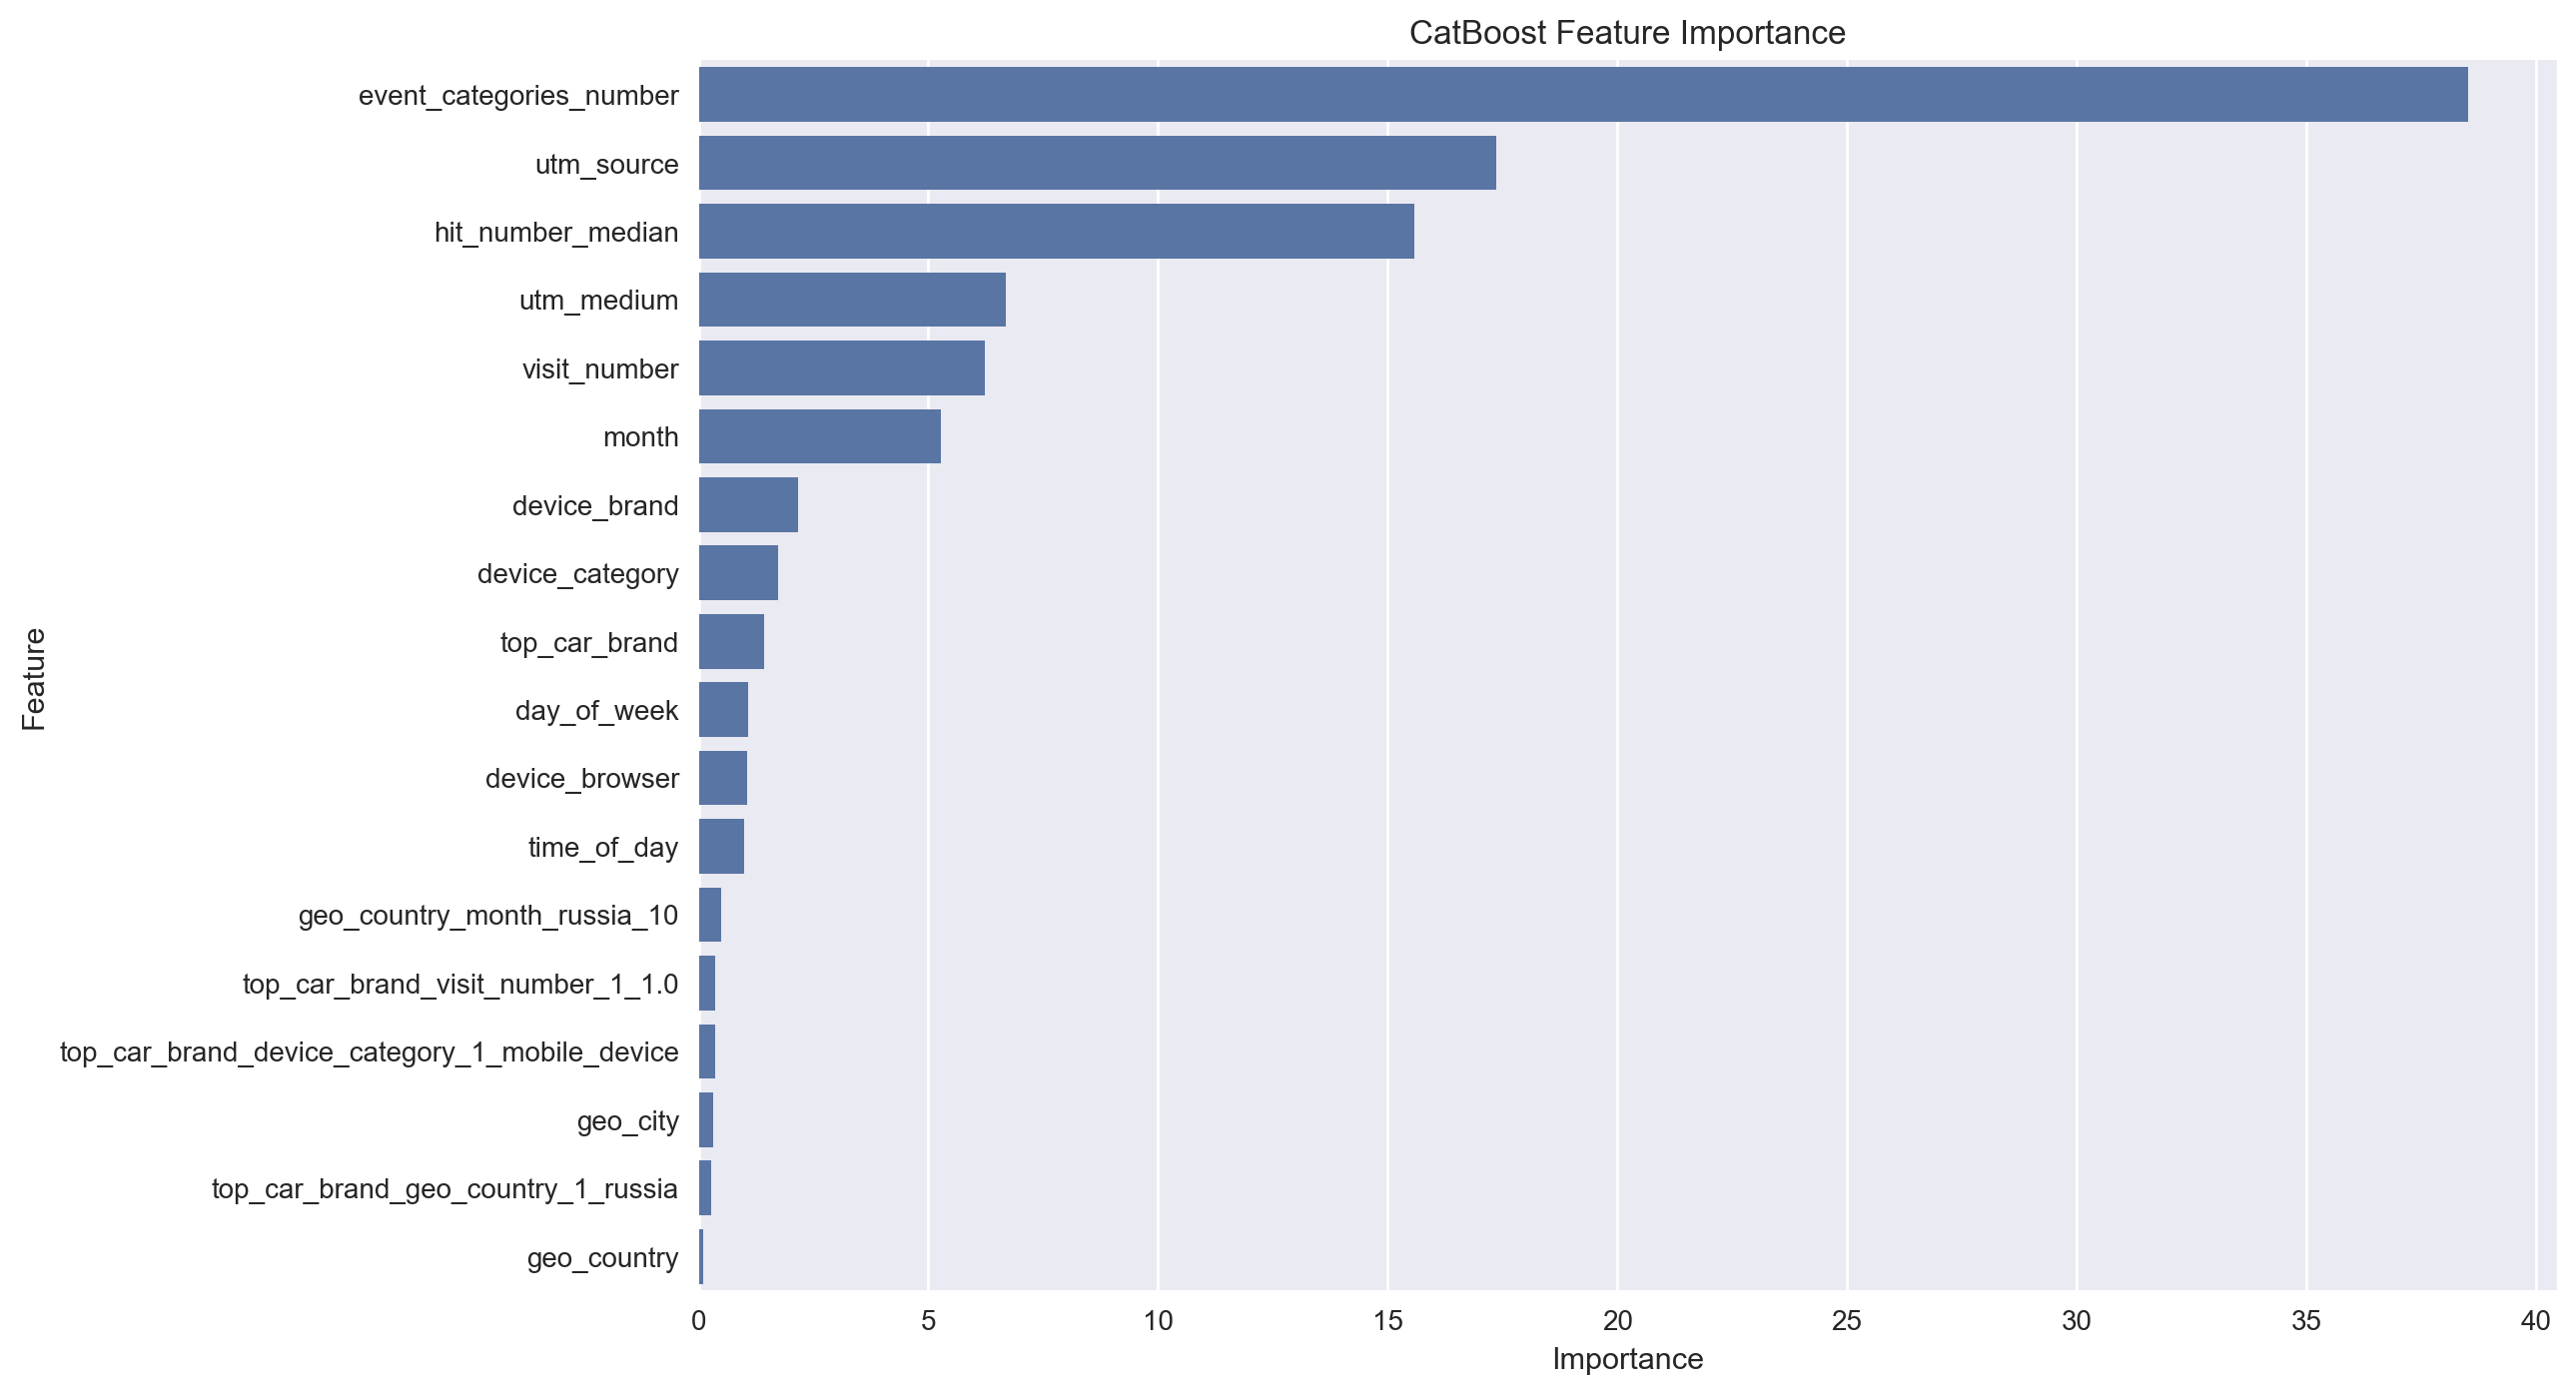

In [21]:
feature_importance = model.get_feature_importance()
feature_names = model.feature_names_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# ввод топ-5 самых важных и 5 наименее важных признаков
print("ТOP-5 Features by Absolute Coefficient Value")
display(importance_df.head())
print("Features with Lowest Predictive Power (Top 5)")
display(importance_df.tail())

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance')
plt.show()

## Выводы:
- модель обучалась 5мин16сек, с кросс-валидацией 27мин
- модель достигла метрик *ROC-AUC*: 0.8711, *PR-AUC*: 0.2402, после кросс-валидации метрики стали несколько хуже (незначительно)
- наиболее важные признаки:
    - `event_categories_number` - количество действий, совершаемых пользователем
    - `utm_source` - канал привлечения
    - `hit_number_median` - медианное значение порядковых номеров событий в рамках сессии
    - `utm-medium` - тип привлечения
    - `visit_number` - порядковый номер визита
    - `month` - месяц визита
- наименее важные признаки:
    - `geo_country` и `geo_city` - страна и город, откуда пользователь заходит на сайт

# Gradient Boosting

## Baseline

In [22]:
%%time
# параметры модели 
params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'max_features': 'sqrt',
    'subsample': 0.8,
    'random_state': RANDOM_STATE
}

# обучение модели
model = Pipeline([
    # обработка признаков
    ('preprocessor', ColumnTransformer(
        transformers=[
            # стандартизация числовых признаков
            ('num', StandardScaler(), num_features),
            # OHE категориальных признаков (чуть лучше метрики)
            ('cat', OneHotEncoder(), cat_features)
        ])
    ),
    ('classifier', GradientBoostingClassifier(**params)
     )
    ])


model.fit(X_train_val, y_train_val)

CPU times: user 55.1 s, sys: 4.31 s, total: 59.4 s
Wall time: 1min


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['event_categories_number',
                                                   'hit_number_median']),
                                                 ('cat', OneHotEncoder(),
                                                  ['top_car_brand',
                                                   'visit_number', 'utm_source',
                                                   'utm_medium',
                                                   'device_category',
                                                   'device_brand',
                                                   'device_browser',
                                                   'geo_country', 'geo_city',
                                                   'month', 'day_of_week',
                                                   'time_of_day',
                                                   'top_car_brand_visit_number_1_1.0',
                                                   'top_car_brand_device_category_1_mobile_device',
                                                   'top_car_brand_geo_country_1_russia',
                                                   'geo_country_month_russia_10'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            max_features='sqrt',
                                            min_samples_leaf=10,
                                            min_samples_split=20,
                                            n_estimators=200, random_state=42,
                                            subsample=0.8))])

ROC-AUC: 0.8372
PR-AUC: 0.1965
Average Precision: 0.1966


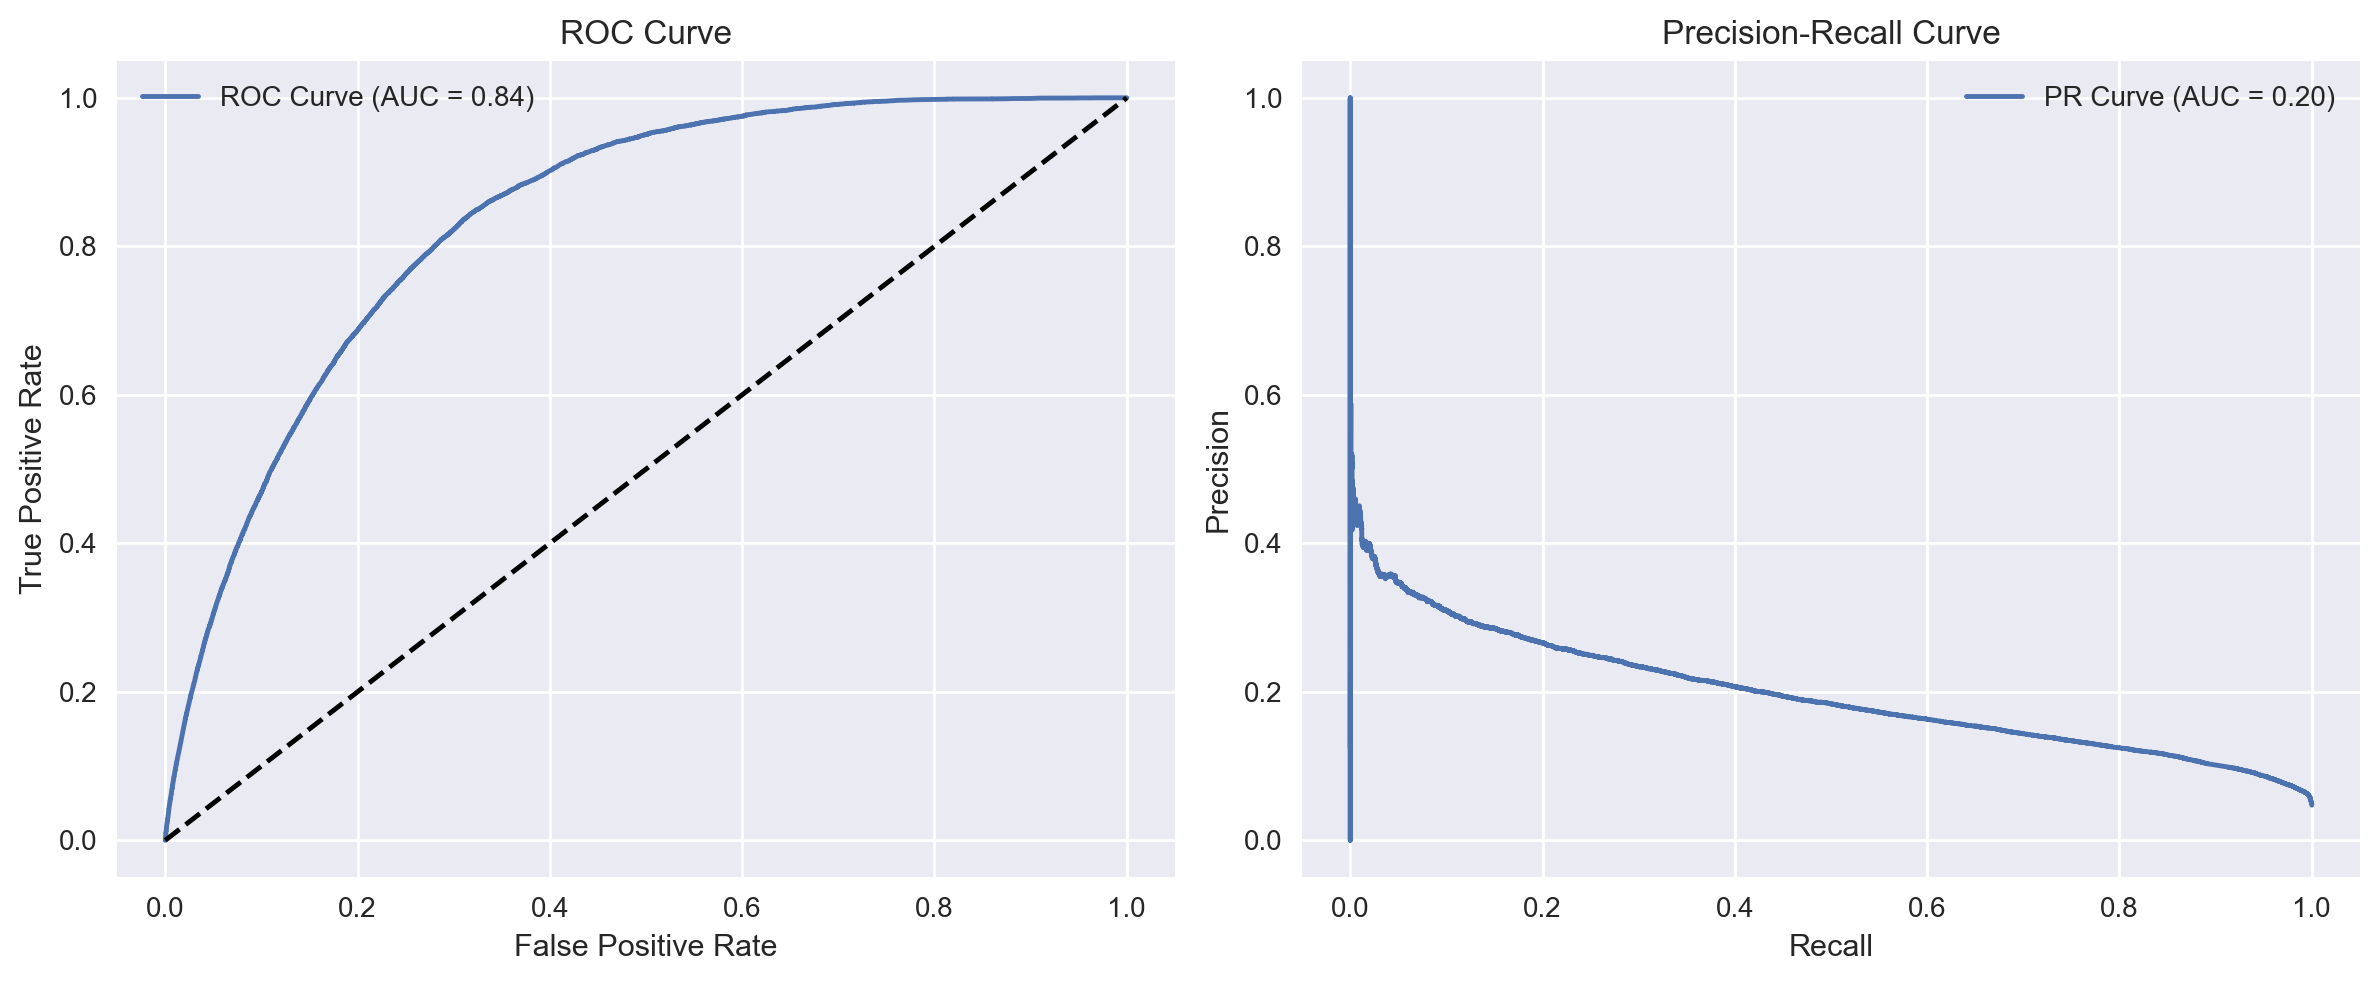

In [24]:
# анализ качества модели 
model_analysis(model, X_test, y_test)

Качество лучше, чем у логистической регресси, но хуже, чем у CatBoost. Пытаться улучшить метрики не будем.

## Сохранение модели

Сохраним обученную модель.

In [ ]:
## Сохранение обученной модели

# формат .joblib
joblib.dump(model, 'models/gb_model.joblib')
# формат .pkl
with open('models/gb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Выводы:
- модель обучалась 1мин
- модель достигла метрик *ROC-AUC*: 0.8372, *PR-AUC*: 0.1965
- метрики лучше, чем метрики Логистической регресии, но хуже метрик CatBoost

# LightGBM

In [31]:
# преобразование категориальных признаков для модели LightGBM
for col in cat_features:
    X_train_val[col] = X_train_val[col].astype('category')
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Указание категориальных признаков (для варианта с category)
categorical_features = list(X_train.select_dtypes(include=['category']).columns)

In [32]:
%%time
## Обучение модели

# параметры модели
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': ['auc'],
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),
    'random_state': RANDOM_STATE
}

# создание Dataset
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    categorical_feature=categorical_features  # только если использовался astype('category')
)

# обучение модели
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[lgb.Dataset(X_val, y_val)]
)

CPU times: user 3min 6s, sys: 1min 6s, total: 4min 13s
Wall time: 28.3 s


ROC-AUC: 0.8731
PR-AUC: 0.2490
Average Precision: 0.2490


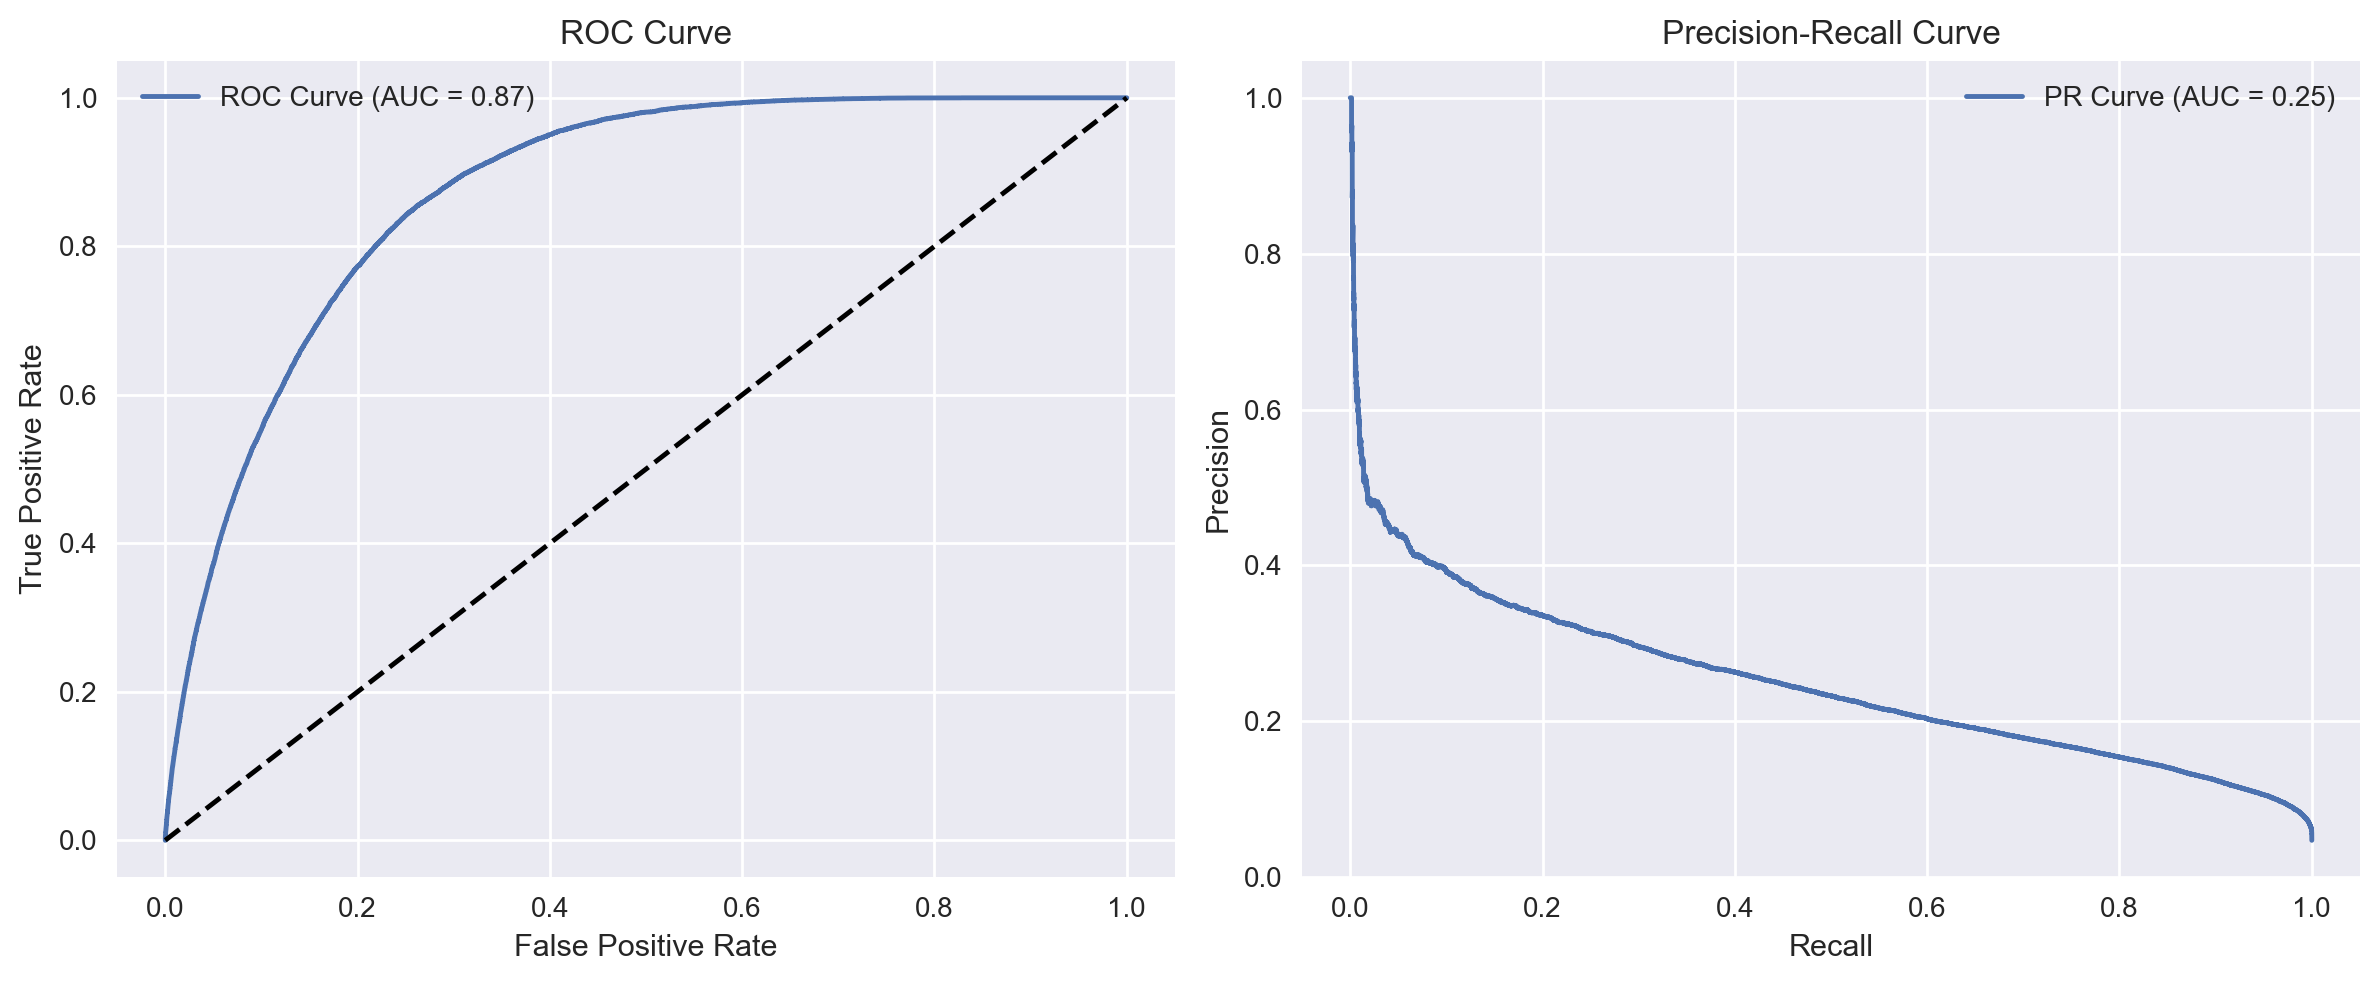

In [33]:
# анализ качества модели на отложенной выборке
model_analysis(model, X_test, y_test, probabilities=False)

Метрики близки к метрикам CatBoost.

## Кросс-валидация

In [34]:
# cоздание Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# параметры модели
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1])  # для дисбаланса
}

# кросс-валидация
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=1000,
    nfold=5,
    stratified=True,
    callbacks=[lgb.early_stopping(stopping_rounds=50)],  # Правильный способ
    seed=RANDOM_STATE,
    return_cvbooster=False
)

print(f"Best AUC: {np.max(cv_results['valid auc-mean']):.4f}")
best_num_boost_round = len(cv_results['valid auc-mean'])

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.872482 + 0.00120064
Best AUC: 0.8725


In [35]:
# обучаем финальную модель
final_model = lgb.train(
    params,
    train_data,
    num_boost_round=len(cv_results['valid auc-mean']),
    valid_sets=[val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's auc: 0.87381


ROC-AUC: 0.8734
PR-AUC: 0.2498
Average Precision: 0.2498


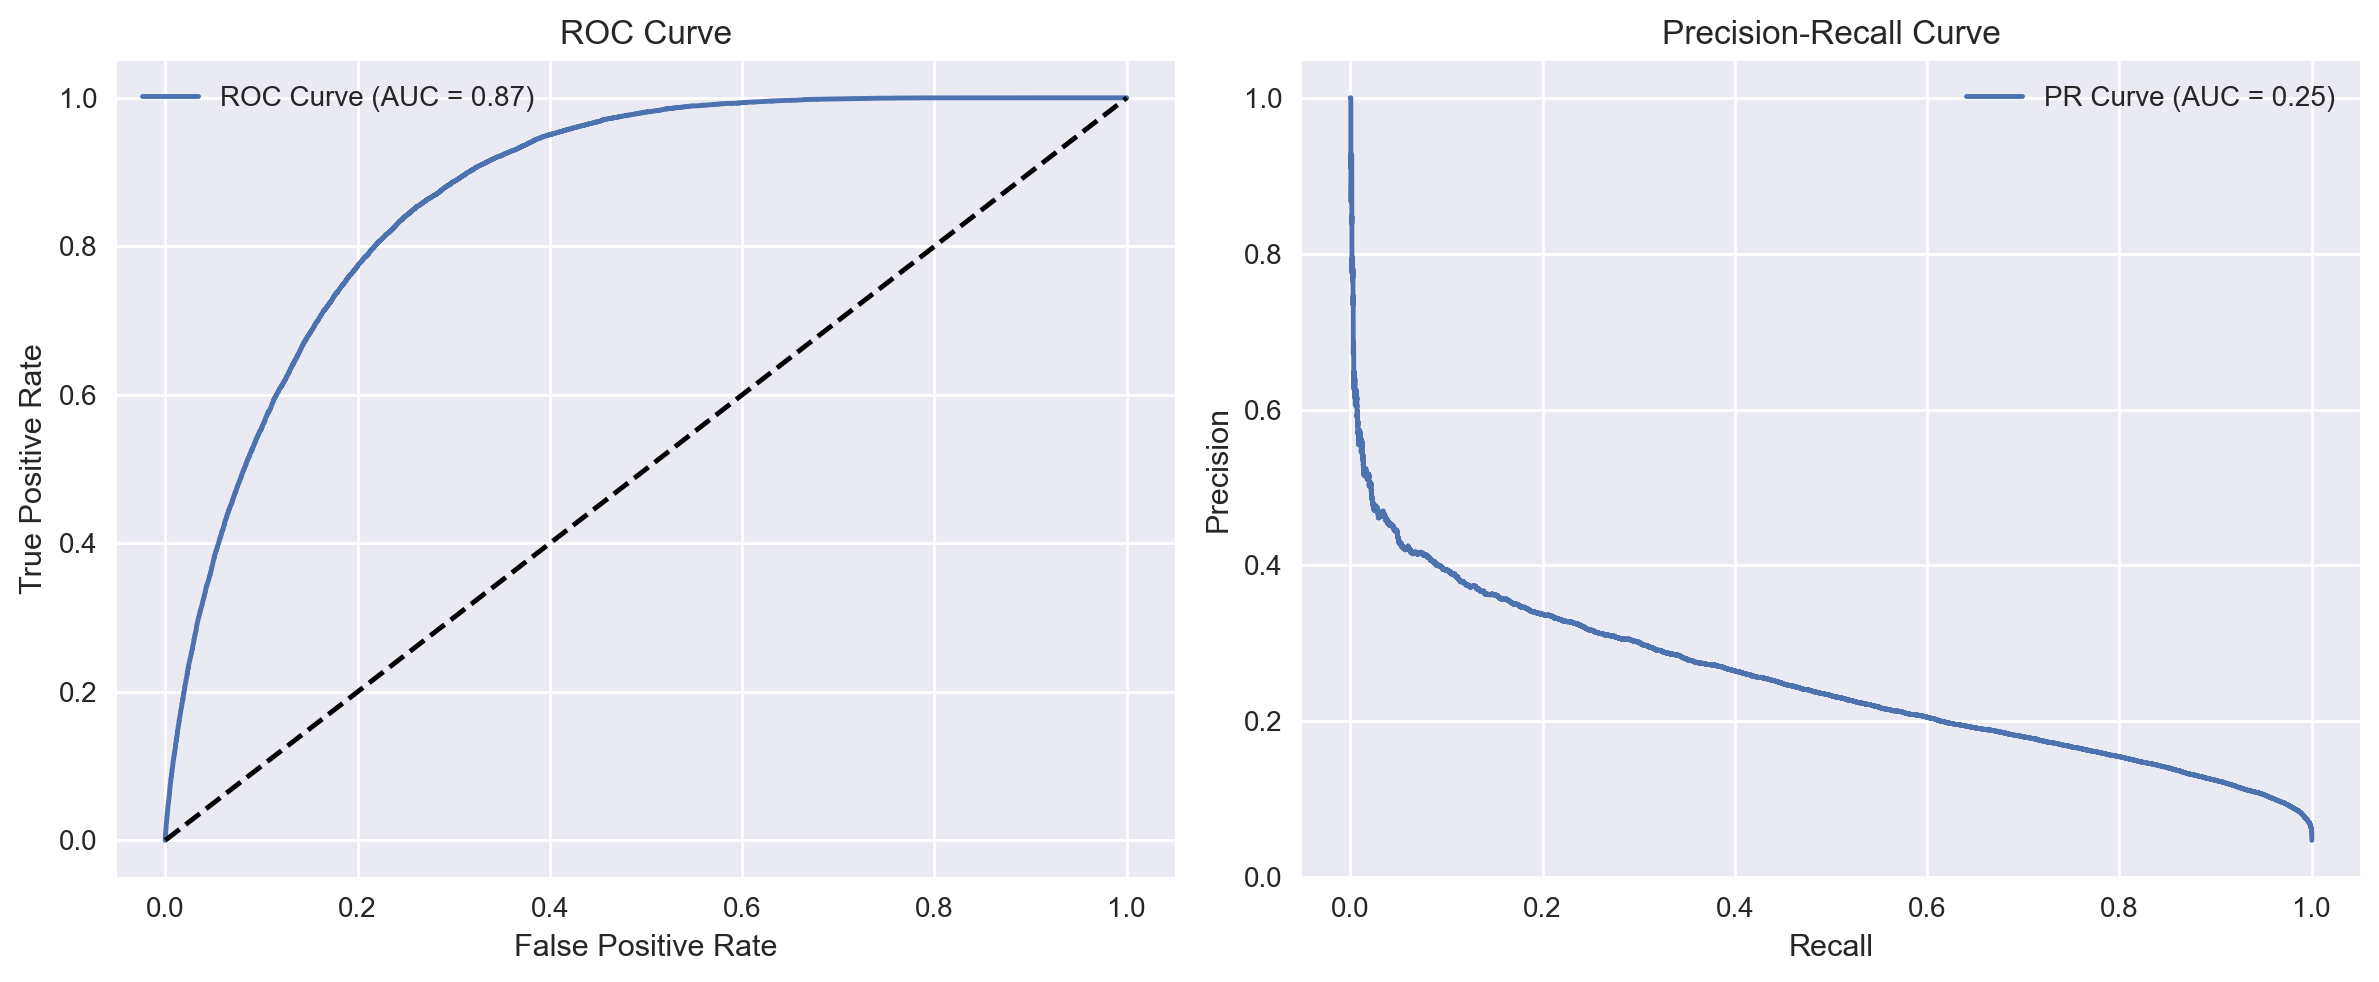

In [36]:
# анализ качества модели на отложенной выборке
model_analysis(final_model, X_test, y_test, probabilities=False)

Метрики незначительно улучшились.

Сохраним обученную модель.

In [ ]:
## Сохранение обученной модели

# формат .txt
model.save_model('models/lightgbm_model.txt')
# формат .joblib
joblib.dump(model, 'models/lightgbm_model.joblib')
# формат .pkl
with open('models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)


## Оценка важности признаков

                                          Feature    Importance
0                         event_categories_number  5.748100e+06
1                               hit_number_median  1.116561e+06
11                                          month  4.589873e+05
4                                      utm_source  2.856321e+05
5                                      utm_medium  2.846643e+05
3                                    visit_number  2.813267e+05
8                                  device_browser  1.635135e+05
12                                    day_of_week  1.585146e+05
7                                    device_brand  1.416412e+05
2                                   top_car_brand  1.124424e+05
10                                       geo_city  8.299557e+04
17                    geo_country_month_russia_10  7.891297e+04
13                                    time_of_day  7.813580e+04
6                                 device_category  6.819882e+04
15  top_car_brand_device_category_1_mobi

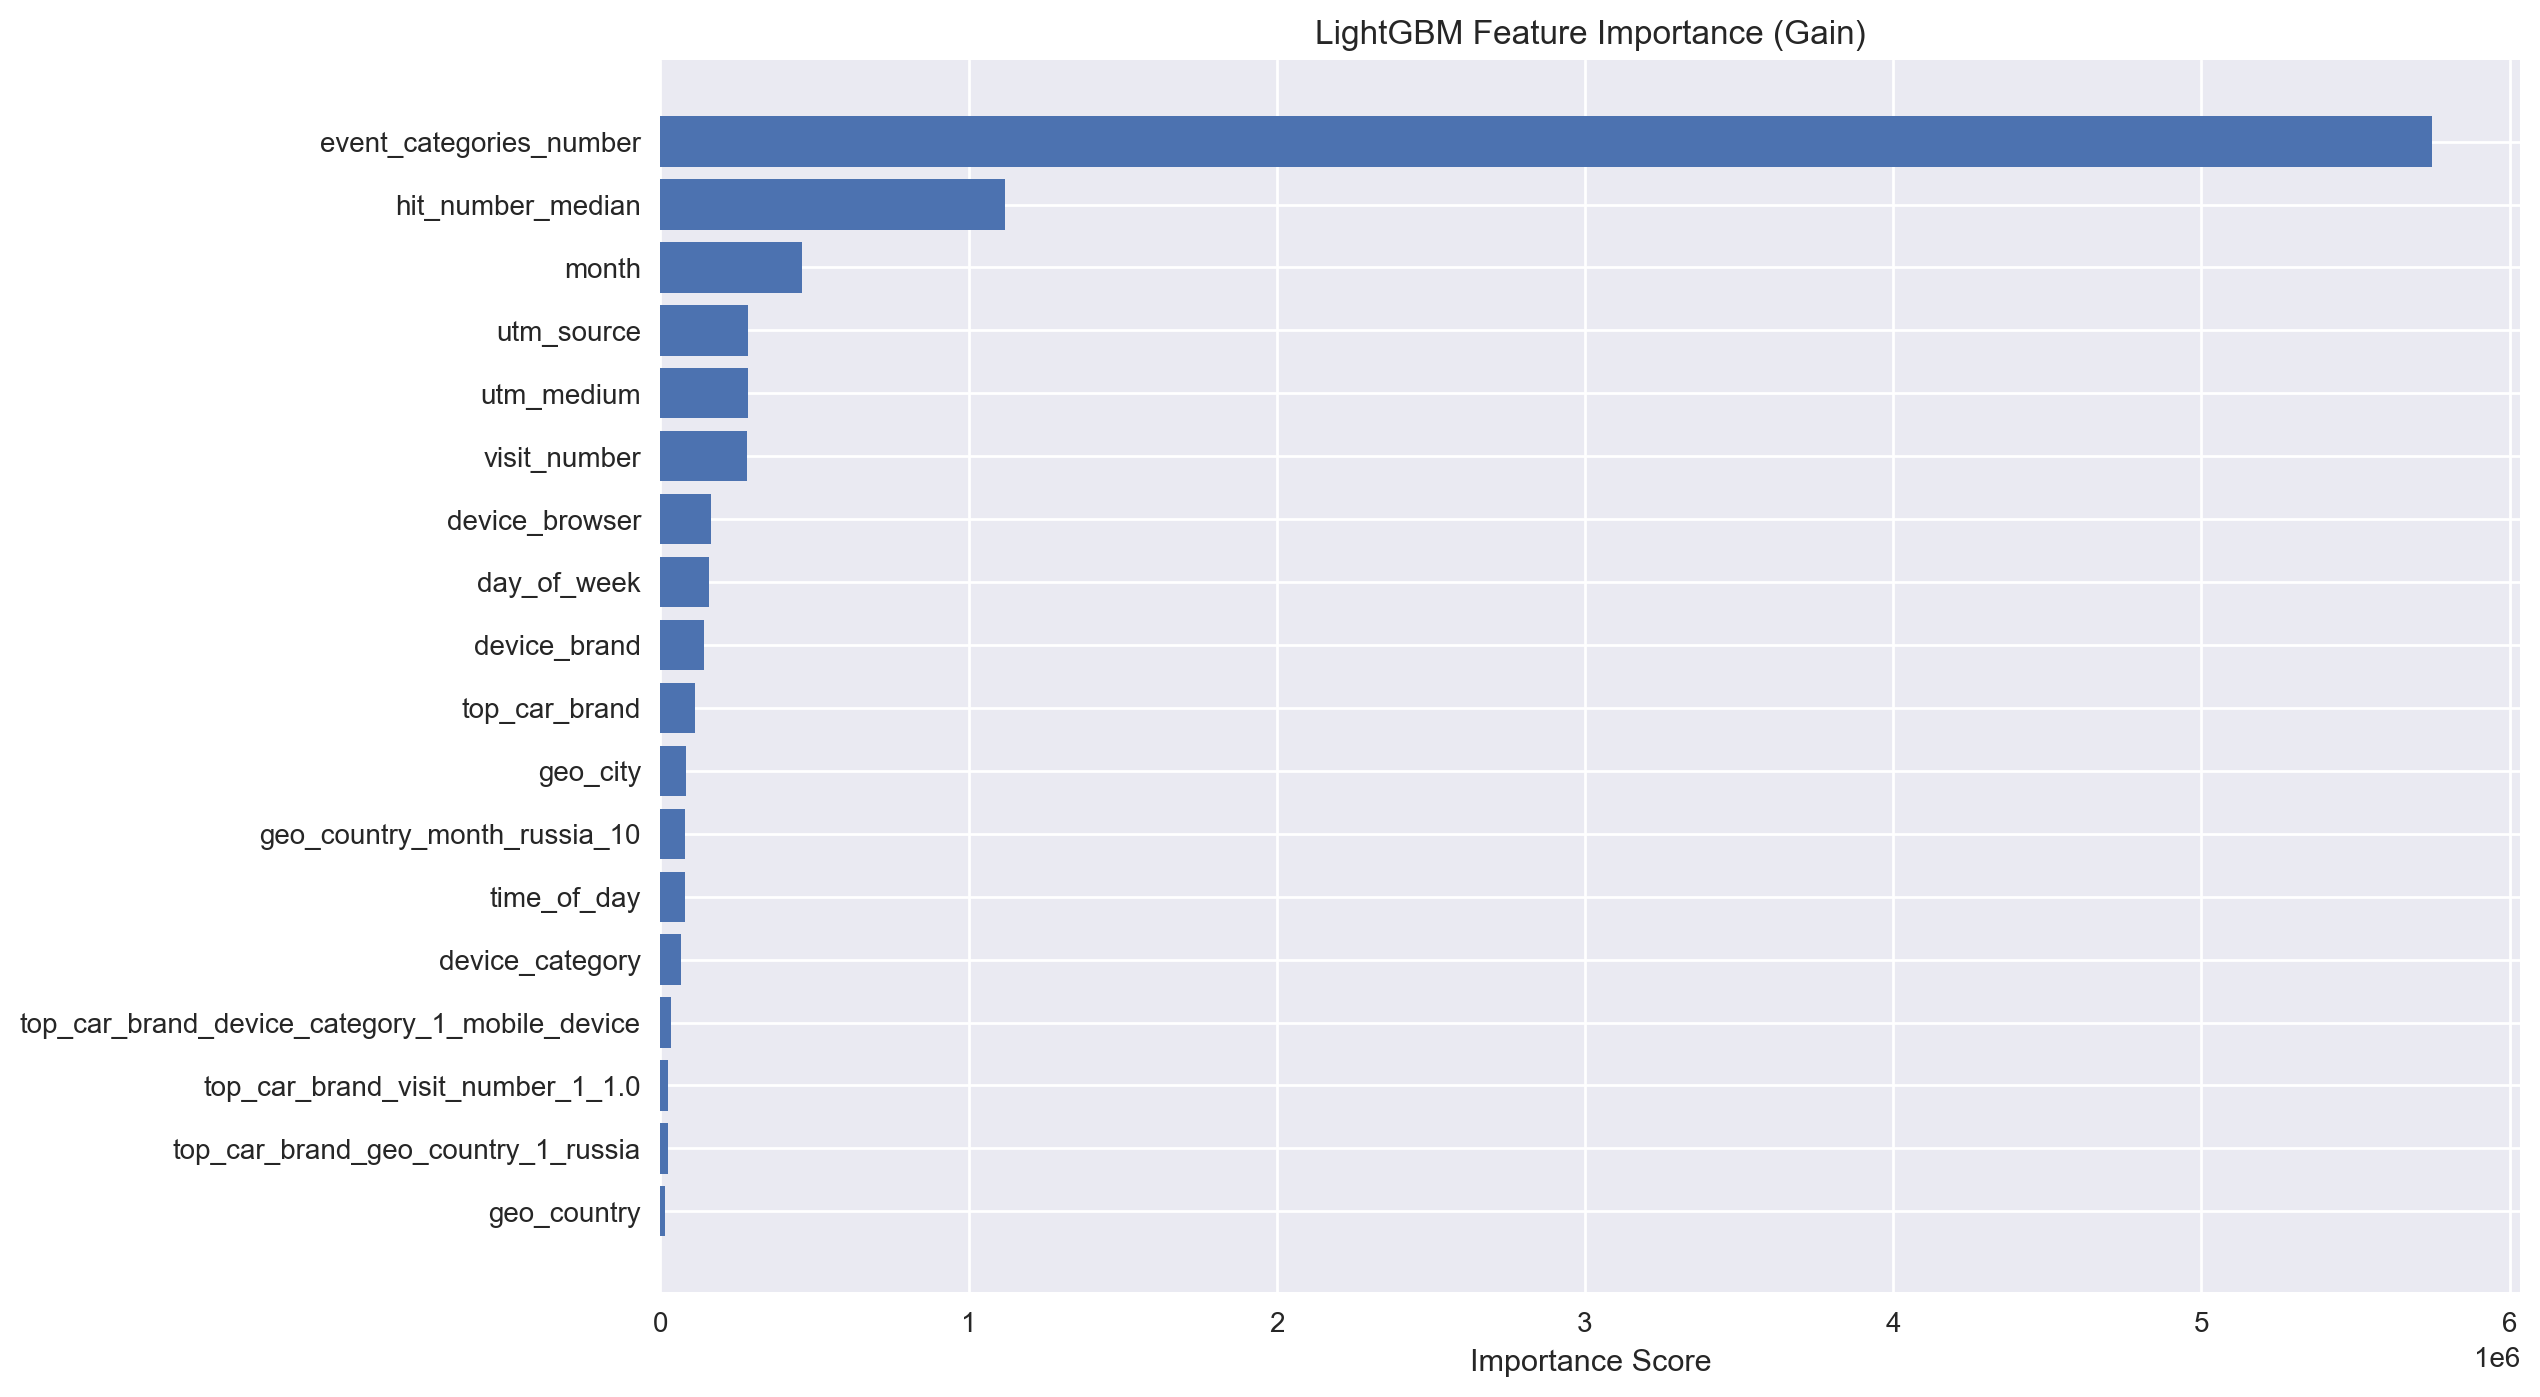

In [38]:
# получаем имена признаков и их важность
feature_names = model.feature_name()  
importance_gain = model.feature_importance(importance_type='gain')

# создаем DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_gain
}).sort_values('Importance', ascending=False)

# вывод призноков по их значимости
print(feature_importance)

# визуализация
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], 
         feature_importance['Importance'])
plt.title('LightGBM Feature Importance (Gain)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()  # Самые важные сверху
plt.show()

## Выводы:
- модель обучалась 28сек, с кросс-валидацией 1мин46сек с кросс-валидацией
- модель достигла метрик *ROC-AUC*: 0.8734, *PR-AUC*: 0.2498, после кросс-валидации метрики стали незначительно лучше
- наиболее важные признаки:
    - `event_categories_number` - количество действий, совершаемых пользователем
    - `hit_number_median` - медианное значение порядковых номеров событий в рамках сессии
    - `month` - месяц визита
    - `utm_source` - канал привлечения    
    - `utm-medium` - тип привлечения
    - `visit_number` - порядковый номер визита
    
- наименее важный признак:
    - `geo_country` 

# Общие выводы по обучению
- наихудшие метрики у модели логистической регрессии, наилучшие - у моделей CatBoost и LightGBM
- наилучшие метрики, которых удалось добиться - *ROC-AUC*: 0.87, *PR-AUC*: 0.25
- наиболее важные признаки для обучения:
    - `event_categories_number` - количество действий, совершаемых пользователем
    - `hit_number_median` - медианное значение порядковых номеров событий в рамках сессии
    - `month` - месяц визита
    - `utm_source` - канал привлечения    
    - `utm-medium` - тип привлечения
    - `visit_number` - порядковый номер визита